In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import scipy
import torch
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import base_network as base_net
import ring_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(imsh, cax=cax, orientation='vertical')
    return cbar

# Get best fit parameters

In [26]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
    K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
    J = prms['J']
#     beta = prms['beta']
#     gE = prms['gE']
#     gI = prms['gI']
#     hE = prms['hE']
#     hI = prms['hI']
    L = prms['L']
#     CVL = prms['CVL']

ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')
ri.set_up_nonlinearity_tensor()

NtE = 50
Nt = NtE*ri.tE
dt = ri.tI/5
T = torch.linspace(0,8*Nt,round(8*Nt/dt)+1)
mask_time = T>(4*Nt)
T_mask = T.cpu().numpy()[mask_time]

N = 50000
Nori = 20
NE = 4*(N//Nori)//5
NI = 1*(N//Nori)//5

this_prms = prms.copy()
this_prms['Nori'] = Nori
this_prms['NE'] = NE
this_prms['NI'] = NI

Loading previously saved nonlinearity
Using cpu


# Simulate unstructured network, where peak input goes to all locations

In [4]:
reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,this_prms,eX)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()

np.save('unstruct_opto_sol',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  6.104083999999999  s

Integrating base network took  1173.115717  s

Integrating opto network took  1118.7335600000001  s



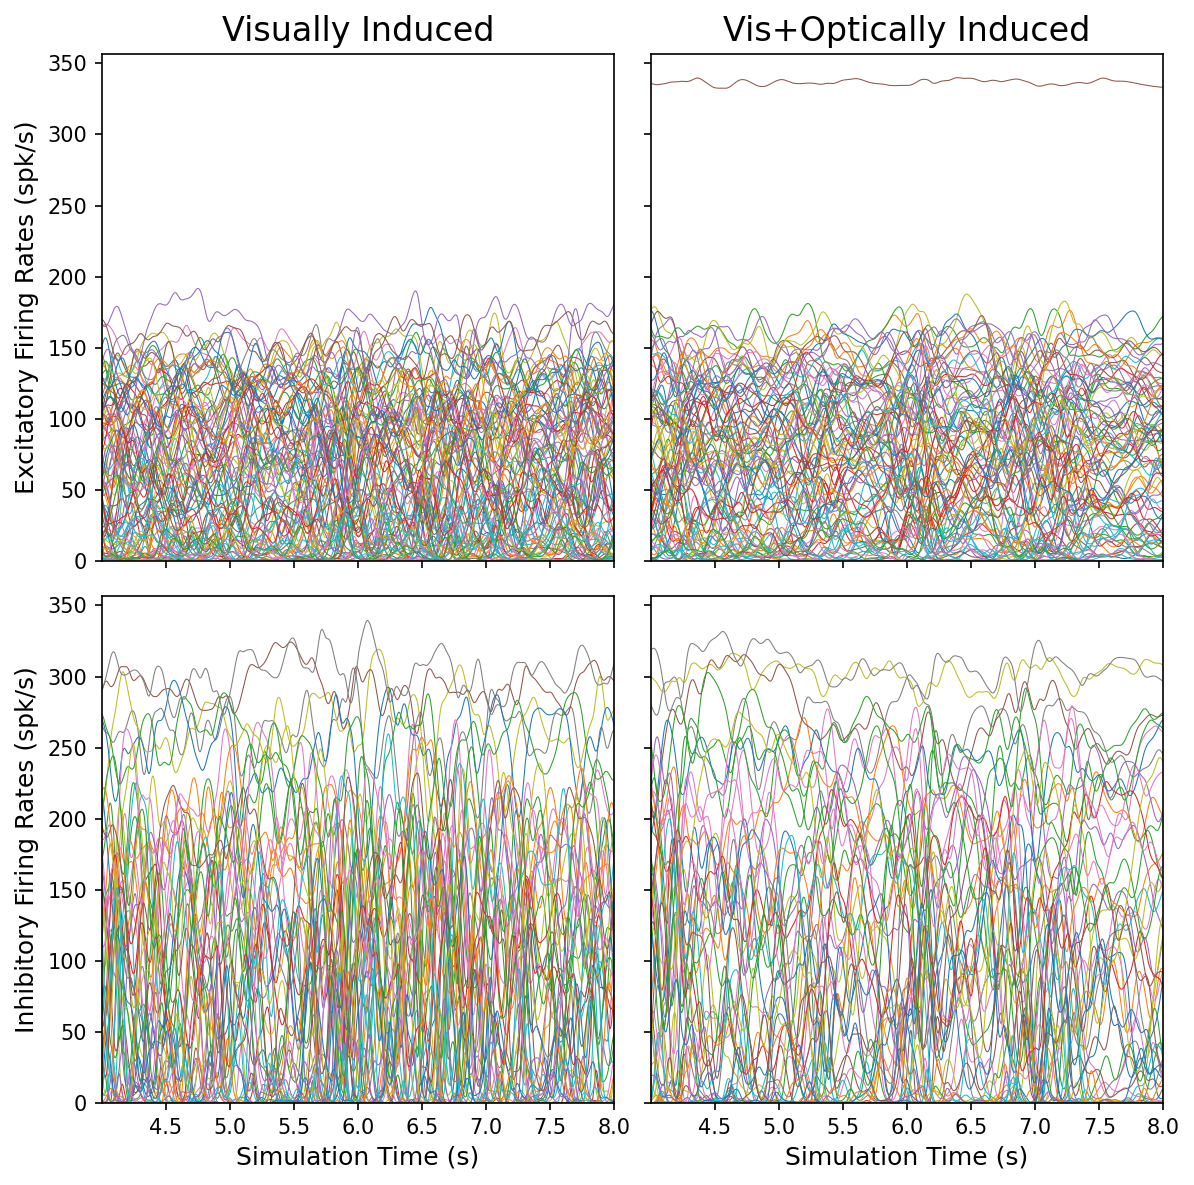

In [5]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [6]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

57.52335
59.7337
2.2103486

57.211678
60.96954
21.53654

-0.021253210356733575


# Find level of increased disorder that gives reshuffling

In [7]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  5.918745999999828  s

Integrating base network took  2007.679779  s

Integrating opto network took  2280.661354  s



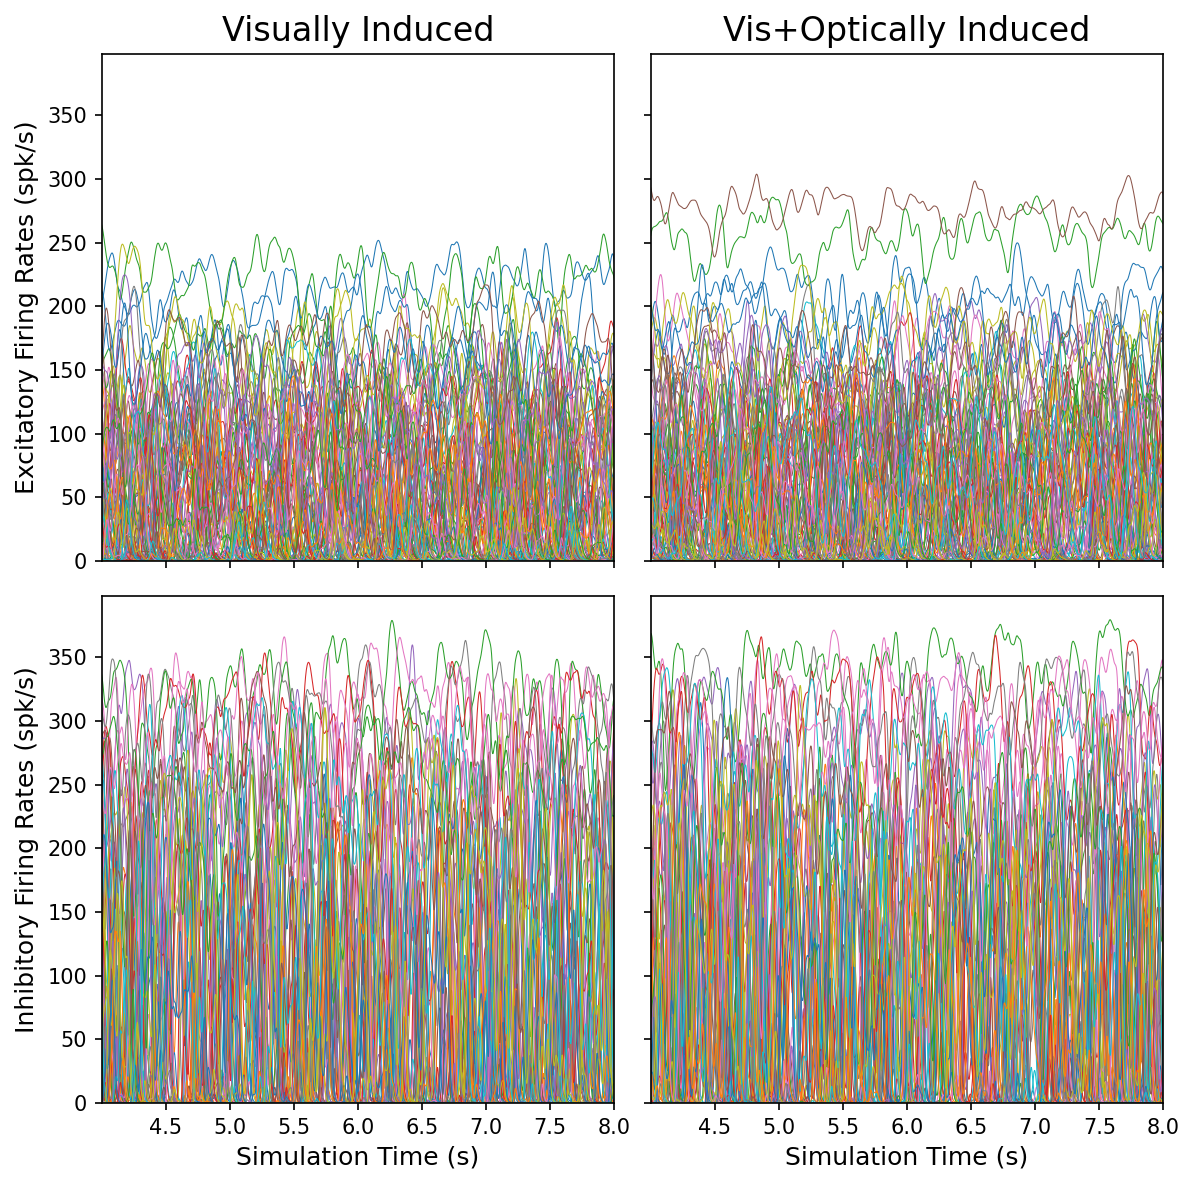

In [8]:
fig,axs = plt.subplots(2,2,figsize=(8,8),dpi=150,sharex=True,sharey=True)

axs[0,0].plot(T_mask,base_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[0,1].plot(T_mask,opto_dynas[net.C_all[0],:][::80,:].T,lw=0.5)
axs[1,0].plot(T_mask,base_dynas[net.C_all[1],:][::20,:].T,lw=0.5)
axs[1,1].plot(T_mask,opto_dynas[net.C_all[1],:][::20,:].T,lw=0.5)

axs[0,0].set_xlim(min(T_mask),max(T_mask))
axs[0,0].set_ylim(0,None)

axs[1,0].set_xlabel('Simulation Time (s)',fontsize=12)
axs[1,1].set_xlabel('Simulation Time (s)',fontsize=12)

axs[0,0].set_ylabel('Excitatory Firing Rates (spk/s)',fontsize=12)
axs[1,0].set_ylabel('Inhibitory Firing Rates (spk/s)',fontsize=12)

axs[0,0].set_title('Visually Induced',fontsize=16)
axs[0,1].set_title('Vis+Optically Induced',fontsize=16)

fig.tight_layout()

In [9]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

53.751568
56.171364
2.4197912

59.739685
62.763695
21.906948

-0.11405568861055522


In [10]:
disord_factor = 2.0

disord_prms = this_prms.copy()
disord_prms['K'] = int(this_prms['K']/disord_factor)
disord_prms['J'] = this_prms['J']*(this_prms['K']/disord_prms['K'])

reload(su)

start = time.process_time()

# net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX)
net,M,H,B,LAS,eps = su.gen_ring_disorder_tensor(0,disord_prms,eX*disord_factor)

print("Generating disorder took ",time.process_time() - start," s")
print('')

start = time.process_time()

base_sol,_ = integ.sim_dyn_tensor(ri,T,0.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
base_dynas = base_sol[:,mask_time].cpu().numpy()

np.save('unstruct_base_sol_more_disord',base_sol.cpu().numpy())

print("Integrating base network took ",time.process_time() - start," s")
print('')

start = time.process_time()

opto_sol,_ = integ.sim_dyn_tensor(ri,T,1.0,M,((bX+aXs[-1])*B)*eps,LAS,net.C_conds[0],mult_tau=True,max_min=60)
opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
opto_dynas = opto_sol[:,mask_time].cpu().numpy()
np.save('unstruct_opto_sol_more_disord',opto_sol.cpu().numpy())

print("Integrating opto network took ",time.process_time() - start," s")
print('')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# base_sol = torch.from_numpy(np.load('unstruct_base_sol_more_disord.npy')).to(device)
# base_rates = torch.mean(base_sol[:,mask_time],axis=1).cpu().numpy()
# base_dynas = base_sol[:,mask_time].cpu().numpy()
# opto_sol = torch.from_numpy(np.load('unstruct_opto_sol_more_disord.npy')).to(device)
# opto_rates = torch.mean(opto_sol[:,mask_time],axis=1).cpu().numpy()
# opto_dynas = opto_sol[:,mask_time].cpu().numpy()

Using cpu
Generating disorder took  6.896883999999773  s

Integrating base network took  2264.1785929999996  s

Integrating opto network took  2232.730813  s



In [11]:
print(np.mean(base_rates))
print(np.mean(opto_rates))
print(np.mean(opto_rates-base_rates))
print()
print(np.std(base_rates))
print(np.std(opto_rates))
print(np.std(opto_rates-base_rates))
print()
print(np.cov(base_rates,opto_rates-base_rates)[0,1] / np.var(opto_rates-base_rates))

54.2666
56.650368
2.383768

60.886368
64.00774
21.359632

-0.07276941552049754


# Read and Plot Cluster Results

In [4]:
structs = np.arange(0,8+1)/8
disords = 3**(np.arange(0,8+1)/8)

print(structs)
print(disords)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[1.         1.14720269 1.31607401 1.50980365 1.73205081 1.98701335
 2.27950706 2.61505663 3.        ]


In [19]:
all_base_means = np.zeros((len(structs),len(disords)))
all_base_stds = np.zeros((len(structs),len(disords)))
all_opto_means = np.zeros((len(structs),len(disords)))
all_opto_stds = np.zeros((len(structs),len(disords)))
all_diff_means = np.zeros((len(structs),len(disords)))
all_diff_stds = np.zeros((len(structs),len(disords)))
all_norm_covs = np.zeros((len(structs),len(disords)))
vsm_base_means = np.zeros((len(structs),len(disords)))
vsm_base_stds = np.zeros((len(structs),len(disords)))
vsm_opto_means = np.zeros((len(structs),len(disords)))
vsm_opto_stds = np.zeros((len(structs),len(disords)))
vsm_diff_means = np.zeros((len(structs),len(disords)))
vsm_diff_stds = np.zeros((len(structs),len(disords)))
vsm_norm_covs = np.zeros((len(structs),len(disords)))
timeouts = np.zeros((len(structs),len(disords),50))

for struct_idx,struct in enumerate(structs):
    for disord_idx,disord in enumerate(disords):
        with open('./../results/vary_struct_{:d}_disord_{:d}'.format(struct_idx,disord_idx)+'.pkl', 'rb') as\
                handle:
            res_dict = pickle.load(handle)
        
        all_base_means[struct_idx,disord_idx] = res_dict['all_base_means']
        all_base_stds[struct_idx,disord_idx] = res_dict['all_base_stds']
        all_opto_means[struct_idx,disord_idx] = res_dict['all_opto_means']
        all_opto_stds[struct_idx,disord_idx] = res_dict['all_opto_stds']
        all_diff_means[struct_idx,disord_idx] = res_dict['all_diff_means']
        all_diff_stds[struct_idx,disord_idx] = res_dict['all_diff_stds']
        all_norm_covs[struct_idx,disord_idx] = res_dict['all_norm_covs']
        vsm_base_means[struct_idx,disord_idx] = res_dict['vsm_base_means']
        vsm_base_stds[struct_idx,disord_idx] = res_dict['vsm_base_stds']
        vsm_opto_means[struct_idx,disord_idx] = res_dict['vsm_opto_means']
        vsm_opto_stds[struct_idx,disord_idx] = res_dict['vsm_opto_stds']
        vsm_diff_means[struct_idx,disord_idx] = res_dict['vsm_diff_means']
        vsm_diff_stds[struct_idx,disord_idx] = res_dict['vsm_diff_stds']
        vsm_norm_covs[struct_idx,disord_idx] = res_dict['vsm_norm_covs']
        timeouts[struct_idx,disord_idx] = res_dict['timeouts']

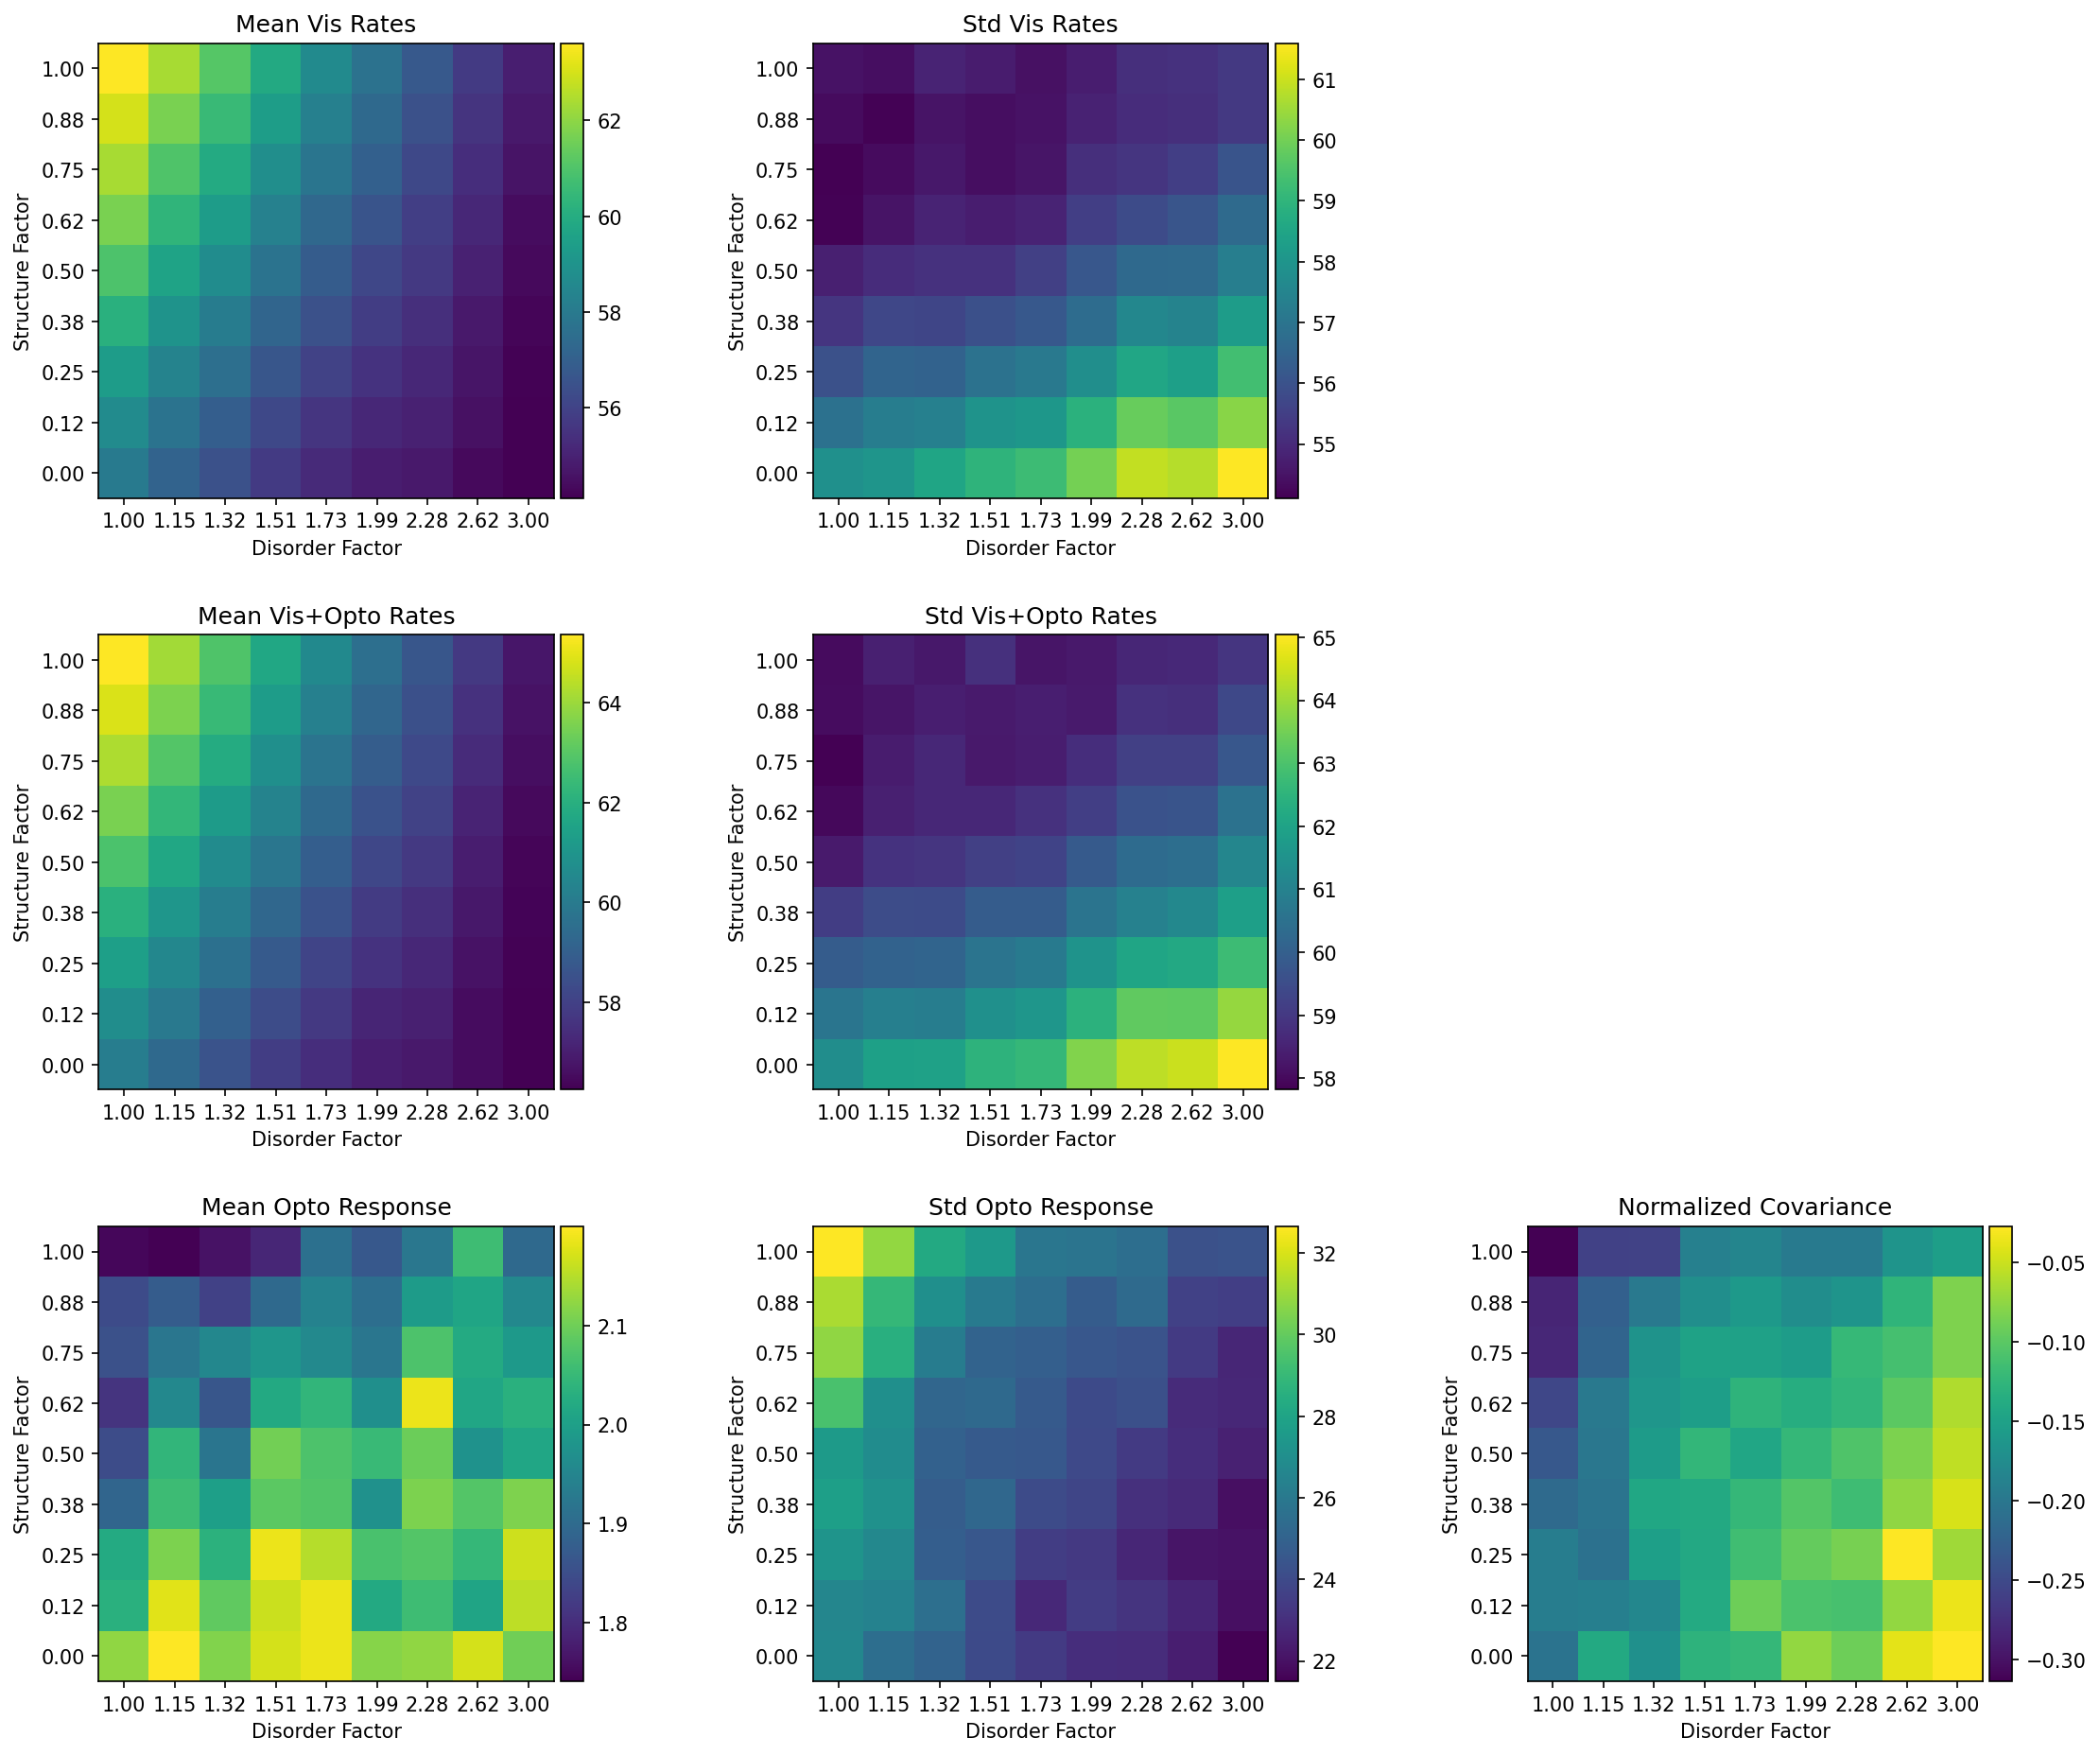

In [16]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
            axs[i,j].set_xticks(np.arange(len(disords)),['{:.2f}'.format(disord) for disord in disords],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Disorder Factor')
            axs[i,j].set_ylabel('Structure Factor')

# Read and plot struct vs J results

In [27]:
structs = np.arange(0,8+1)/8
Js = prms['J']*3**(np.arange(0,8+1)/8)

print(structs)
print(Js)

[0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
[0.00014202 0.00016293 0.00018691 0.00021442 0.00024599 0.0002822
 0.00032374 0.00037139 0.00042606]


In [278]:
sim_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
sim_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
sim_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
sim_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
sim_all_base_means = np.zeros((len(structs),len(Js)))
sim_all_base_stds = np.zeros((len(structs),len(Js)))
sim_all_opto_means = np.zeros((len(structs),len(Js)))
sim_all_opto_stds = np.zeros((len(structs),len(Js)))
sim_all_diff_means = np.zeros((len(structs),len(Js)))
sim_all_diff_stds = np.zeros((len(structs),len(Js)))
sim_all_norm_covs = np.zeros((len(structs),len(Js)))
sim_vsm_base_means = np.zeros((len(structs),len(Js)))
sim_vsm_base_stds = np.zeros((len(structs),len(Js)))
sim_vsm_opto_means = np.zeros((len(structs),len(Js)))
sim_vsm_opto_stds = np.zeros((len(structs),len(Js)))
sim_vsm_diff_means = np.zeros((len(structs),len(Js)))
sim_vsm_diff_stds = np.zeros((len(structs),len(Js)))
sim_vsm_norm_covs = np.zeros((len(structs),len(Js)))
sim_Lexps = np.zeros((len(structs),len(Js),2))
sim_timeouts = np.zeros((len(structs),len(Js),2))

dmft_μrEs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_μrIs = np.zeros((3,Nori,len(structs),len(Js)))
dmft_ΣrEs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_ΣrIs = np.zeros((4,Nori,len(structs),len(Js)))
dmft_all_base_means = np.zeros((len(structs),len(Js)))
dmft_all_base_stds = np.zeros((len(structs),len(Js)))
dmft_all_opto_means = np.zeros((len(structs),len(Js)))
dmft_all_opto_stds = np.zeros((len(structs),len(Js)))
dmft_all_diff_means = np.zeros((len(structs),len(Js)))
dmft_all_diff_stds = np.zeros((len(structs),len(Js)))
dmft_all_norm_covs = np.zeros((len(structs),len(Js)))
dmft_vsm_base_means = np.zeros((len(structs),len(Js)))
dmft_vsm_base_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_means = np.zeros((len(structs),len(Js)))
dmft_vsm_opto_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_means = np.zeros((len(structs),len(Js)))
dmft_vsm_diff_stds = np.zeros((len(structs),len(Js)))
dmft_vsm_norm_covs = np.zeros((len(structs),len(Js)))
dmft_convs = np.zeros((2,3,len(structs),len(Js)))

for struct_idx,struct in enumerate(structs):
    for J_idx,J in enumerate(Js):
        try:
            with open('./../results/vary_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            sim_μrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrEs'],0)
            sim_μrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['μrIs'],0)
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrEs'],0)
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.mean(res_dict['ΣrIs'],0)
            sim_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            sim_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            sim_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            sim_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            sim_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            sim_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            sim_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            sim_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            sim_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            sim_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            sim_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            sim_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            sim_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            sim_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            sim_Lexps[struct_idx,J_idx] = np.median(res_dict['Lexps'],-2)
            sim_timeouts[struct_idx,J_idx] = np.sum(res_dict['timeouts'],-2)
            
        except:
            sim_μrEs[:,:,struct_idx,J_idx] = np.nan
            sim_μrIs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            sim_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            sim_all_base_means[struct_idx,J_idx] = np.nan
            sim_all_base_stds[struct_idx,J_idx] = np.nan
            sim_all_opto_means[struct_idx,J_idx] = np.nan
            sim_all_opto_stds[struct_idx,J_idx] = np.nan
            sim_all_diff_means[struct_idx,J_idx] = np.nan
            sim_all_diff_stds[struct_idx,J_idx] = np.nan
            sim_all_norm_covs[struct_idx,J_idx] = np.nan
            sim_vsm_base_means[struct_idx,J_idx] = np.nan
            sim_vsm_base_stds[struct_idx,J_idx] = np.nan
            sim_vsm_opto_means[struct_idx,J_idx] = np.nan
            sim_vsm_opto_stds[struct_idx,J_idx] = np.nan
            sim_vsm_diff_means[struct_idx,J_idx] = np.nan
            sim_vsm_diff_stds[struct_idx,J_idx] = np.nan
            sim_vsm_norm_covs[struct_idx,J_idx] = np.nan
            sim_Lexps[struct_idx,J_idx] = np.nan
            sim_timeouts[struct_idx,J_idx] = 0
        
        try:
            with open('./../results/dmft_vary_struct_{:d}_J_{:d}'.format(struct_idx,J_idx)+'.pkl', 'rb') as\
                    handle:
                res_dict = pickle.load(handle)

            dmft_μrEs[:,:,struct_idx,J_idx] = res_dict['μrEs']
            dmft_μrIs[:,:,struct_idx,J_idx] = res_dict['μrIs']
            dmft_ΣrEs[:,:,struct_idx,J_idx] = res_dict['ΣrEs']
            dmft_ΣrIs[:,:,struct_idx,J_idx] = res_dict['ΣrIs']
            dmft_all_base_means[struct_idx,J_idx] = res_dict['all_base_means']
            dmft_all_base_stds[struct_idx,J_idx] = res_dict['all_base_stds']
            dmft_all_opto_means[struct_idx,J_idx] = res_dict['all_opto_means']
            dmft_all_opto_stds[struct_idx,J_idx] = res_dict['all_opto_stds']
            dmft_all_diff_means[struct_idx,J_idx] = res_dict['all_diff_means']
            dmft_all_diff_stds[struct_idx,J_idx] = res_dict['all_diff_stds']
            dmft_all_norm_covs[struct_idx,J_idx] = res_dict['all_norm_covs']
            dmft_vsm_base_means[struct_idx,J_idx] = res_dict['vsm_base_means']
            dmft_vsm_base_stds[struct_idx,J_idx] = res_dict['vsm_base_stds']
            dmft_vsm_opto_means[struct_idx,J_idx] = res_dict['vsm_opto_means']
            dmft_vsm_opto_stds[struct_idx,J_idx] = res_dict['vsm_opto_stds']
            dmft_vsm_diff_means[struct_idx,J_idx] = res_dict['vsm_diff_means']
            dmft_vsm_diff_stds[struct_idx,J_idx] = res_dict['vsm_diff_stds']
            dmft_vsm_norm_covs[struct_idx,J_idx] = res_dict['vsm_norm_covs']
            dmft_convs[:,:,struct_idx,J_idx] = res_dict['convs']
            
        except:
            dmft_μrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_μrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrEs[:,:,struct_idx,J_idx] = np.nan
            dmft_ΣrIs[:,:,struct_idx,J_idx] = np.nan
            dmft_all_base_means[struct_idx,J_idx] = np.nan
            dmft_all_base_stds[struct_idx,J_idx] = np.nan
            dmft_all_opto_means[struct_idx,J_idx] = np.nan
            dmft_all_opto_stds[struct_idx,J_idx] = np.nan
            dmft_all_diff_means[struct_idx,J_idx] = np.nan
            dmft_all_diff_stds[struct_idx,J_idx] = np.nan
            dmft_all_norm_covs[struct_idx,J_idx] = np.nan
            dmft_vsm_base_means[struct_idx,J_idx] = np.nan
            dmft_vsm_base_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_means[struct_idx,J_idx] = np.nan
            dmft_vsm_opto_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_means[struct_idx,J_idx] = np.nan
            dmft_vsm_diff_stds[struct_idx,J_idx] = np.nan
            dmft_vsm_norm_covs[struct_idx,J_idx] = np.nan
            dmft_convs[:,:,struct_idx,J_idx] = False

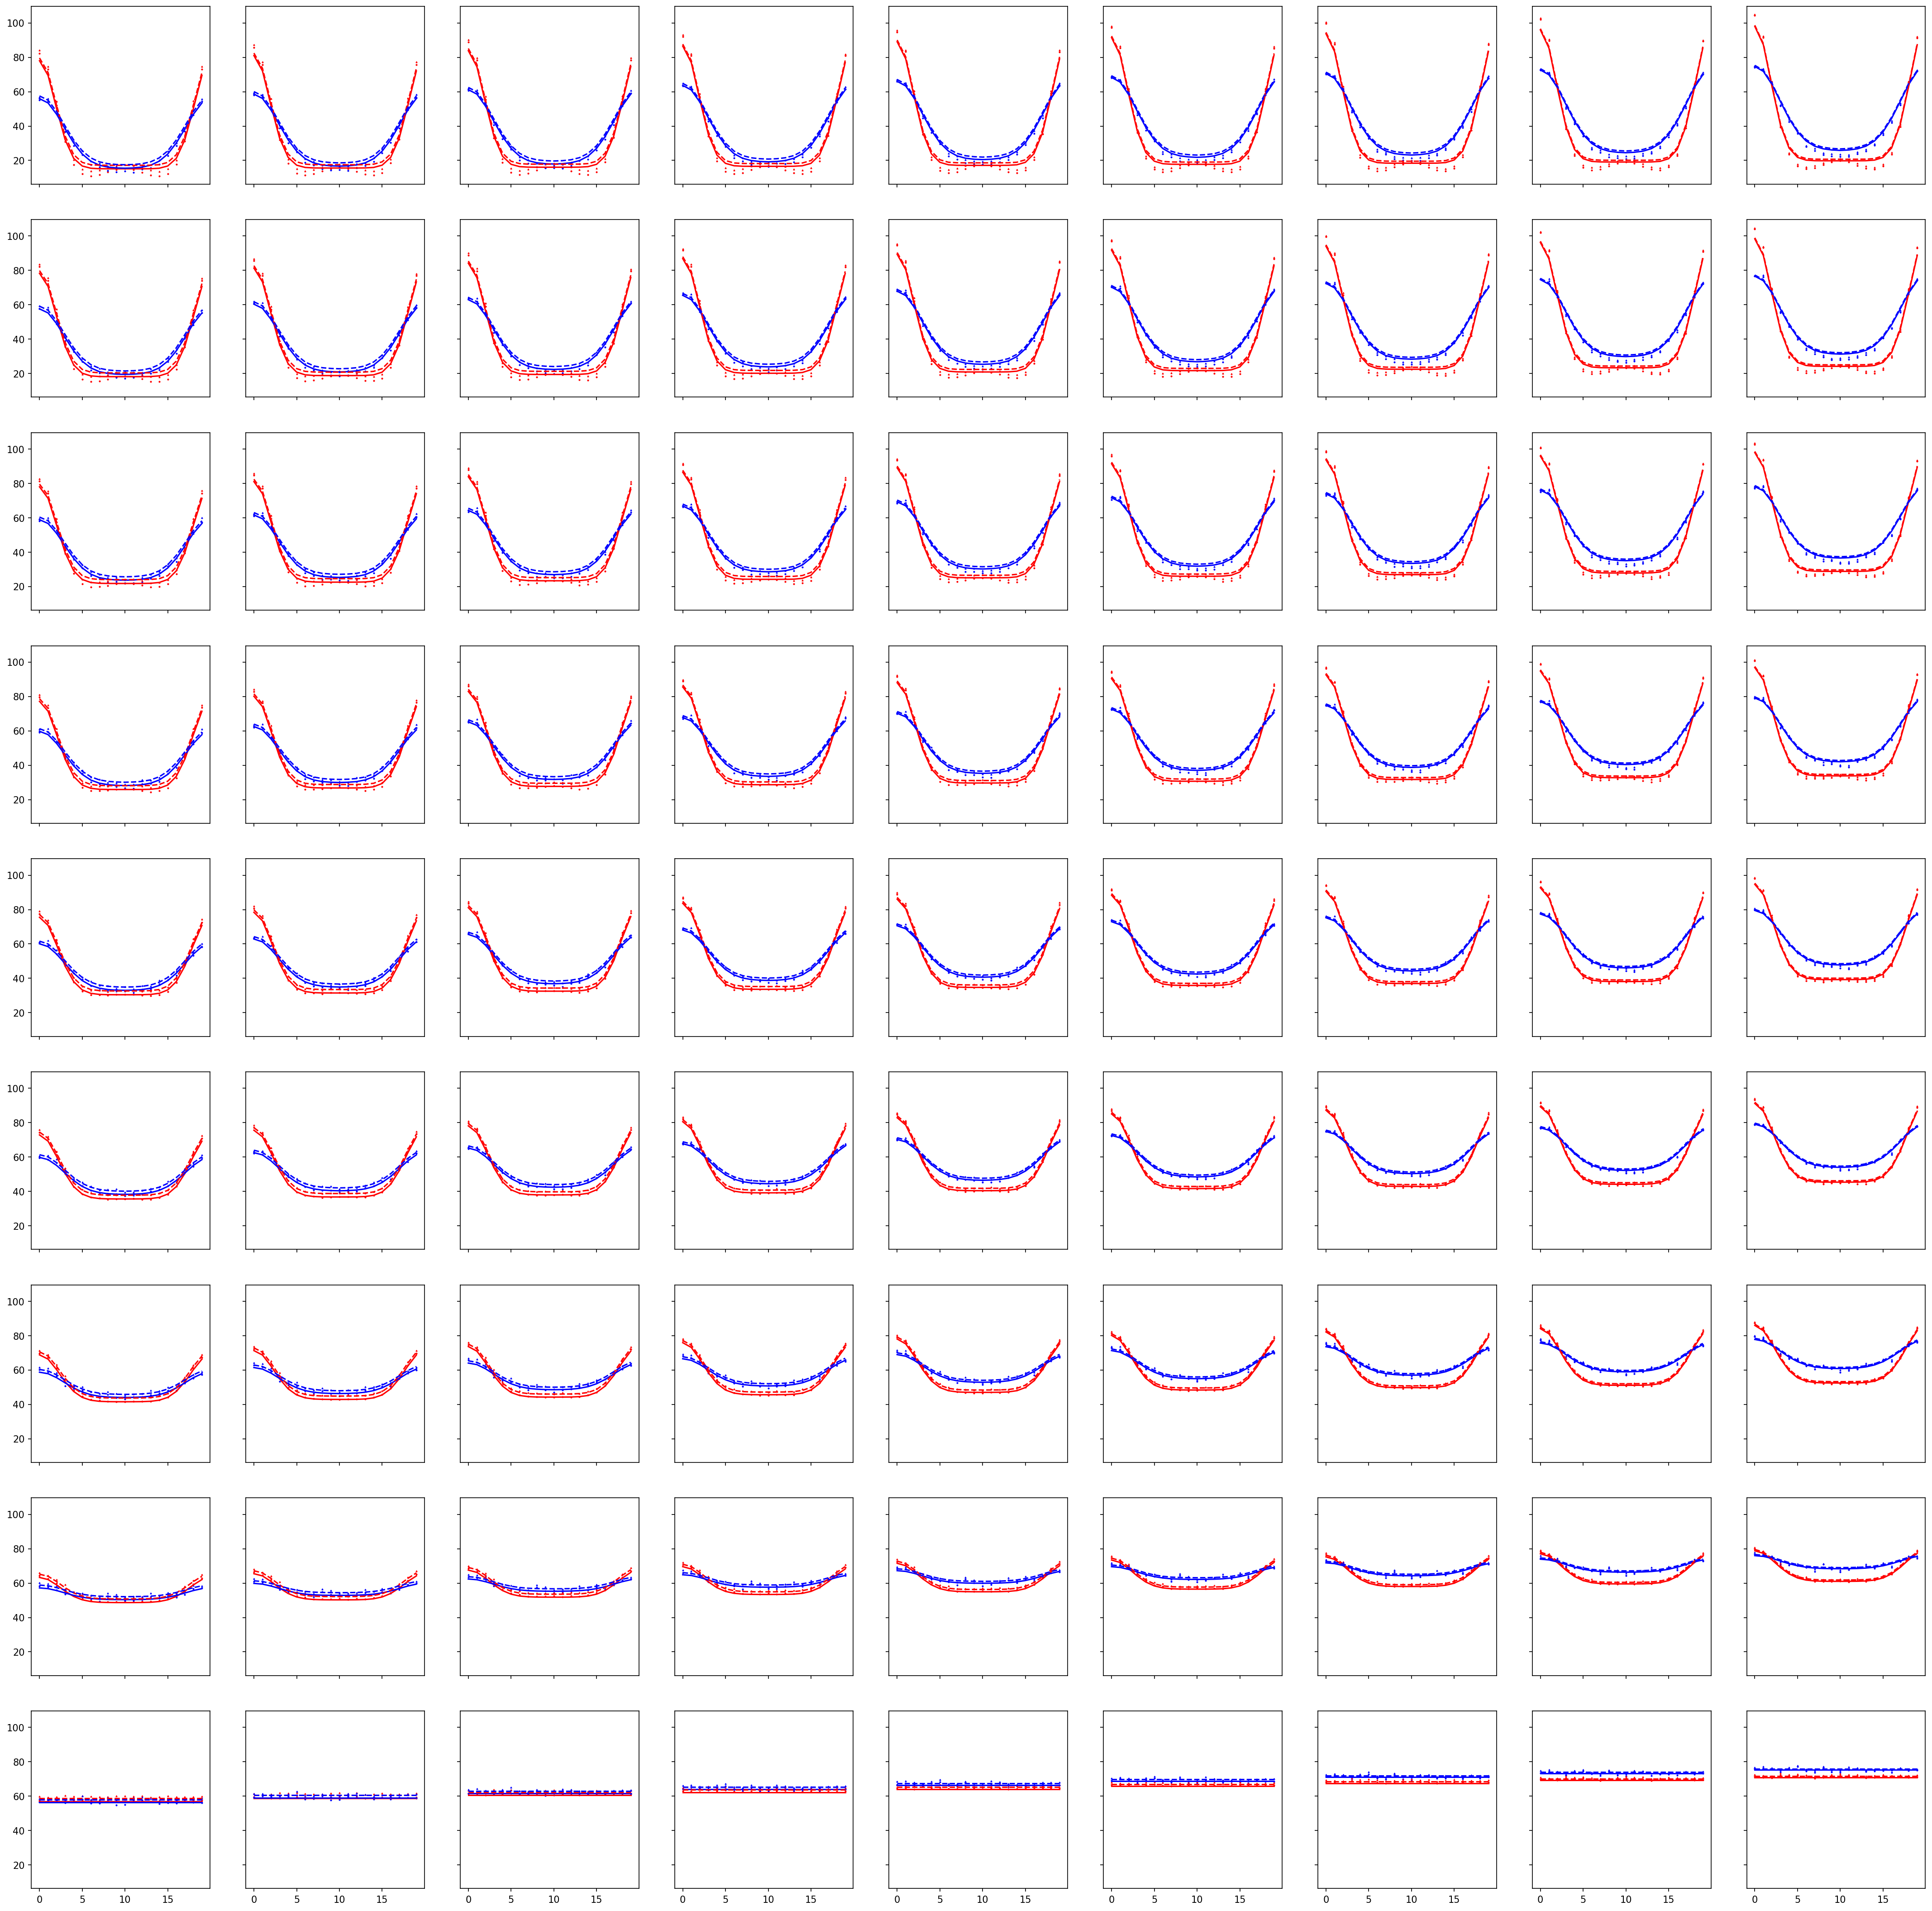

In [241]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_μrEs[0,:,i,j],s=1,c='r')
        axs[8-i,j].scatter(np.arange(20),sim_μrIs[0,:,i,j],s=1,c='b')
        axs[8-i,j].scatter(np.arange(20),sim_μrEs[1,:,i,j],s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_μrIs[1,:,i,j],s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_μrEs[0,:,i,j],'r')
        axs[8-i,j].plot(np.arange(20),dmft_μrIs[0,:,i,j],'b')
        axs[8-i,j].plot(np.arange(20),dmft_μrEs[1,:,i,j],'r--')
        axs[8-i,j].plot(np.arange(20),dmft_μrIs[1,:,i,j],'b--')

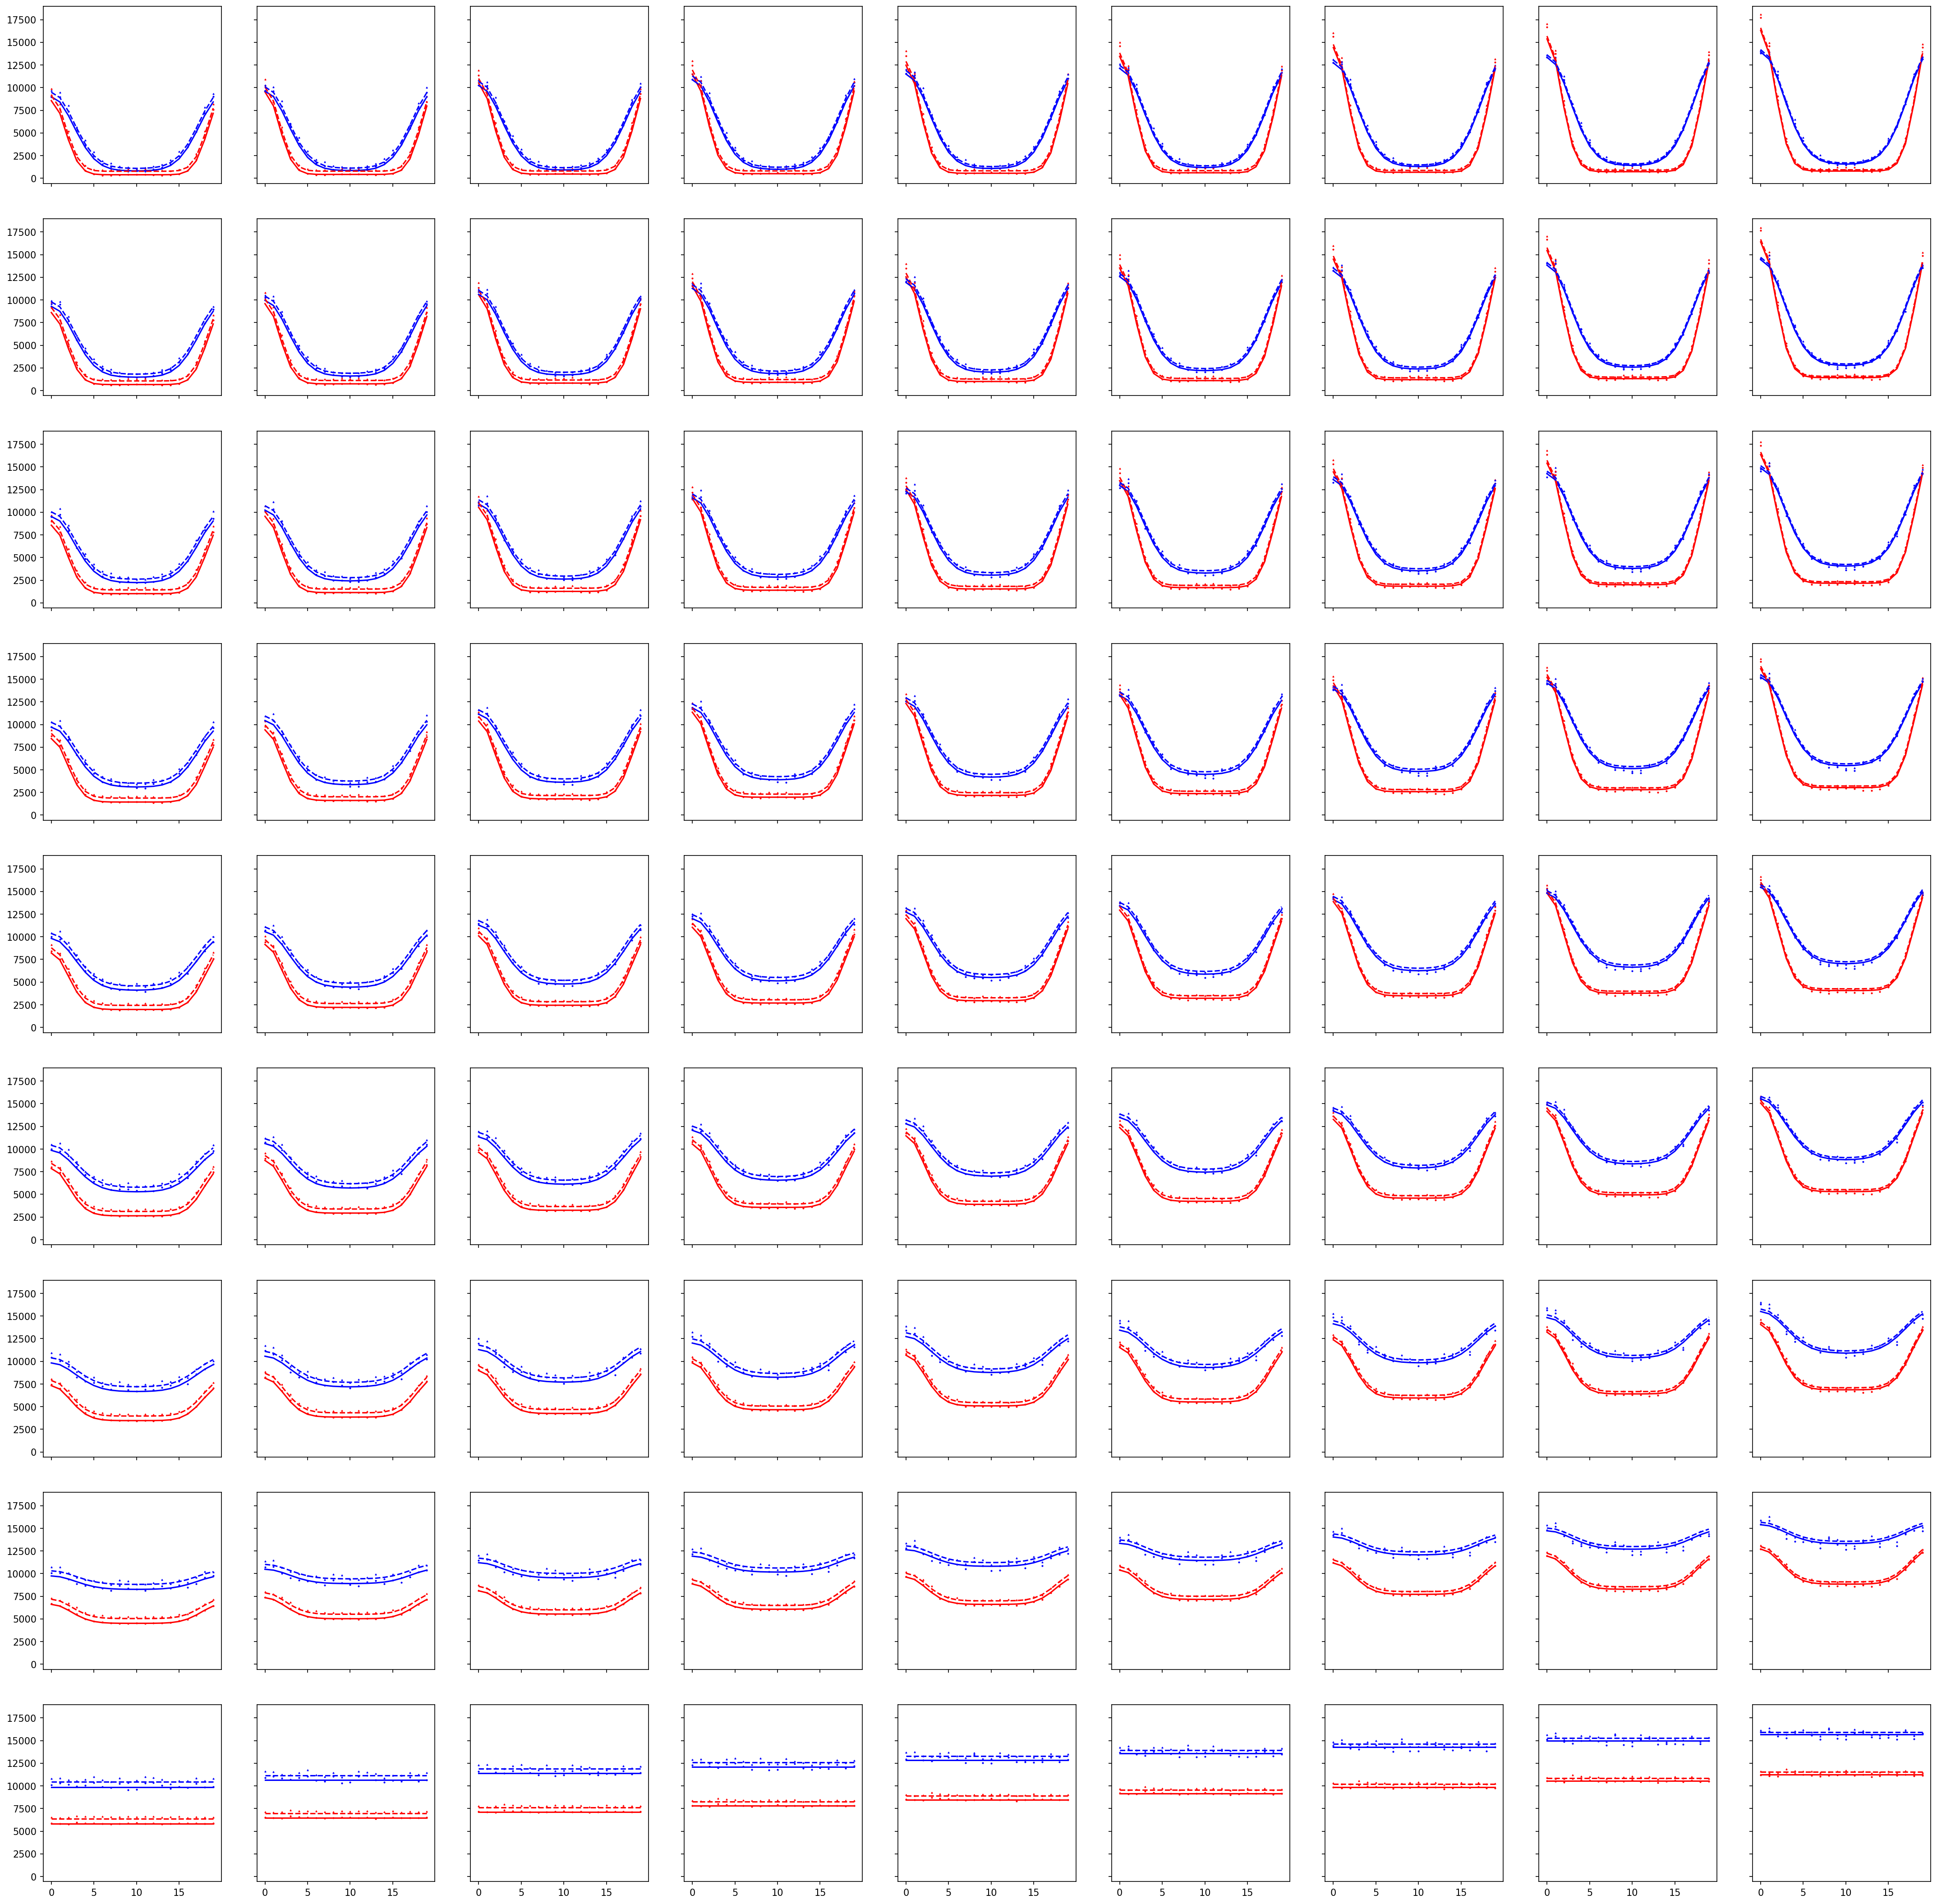

In [242]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[0,:,i,j]+sim_μrEs[0,:,i,j]**2,s=1,c='r')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[0,:,i,j]+sim_μrIs[0,:,i,j]**2,s=1,c='b')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[1,:,i,j]+sim_μrEs[1,:,i,j]**2,s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[1,:,i,j]+sim_μrIs[1,:,i,j]**2,s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[0,:,i,j]+dmft_μrEs[0,:,i,j]**2,'r')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[0,:,i,j]+dmft_μrIs[0,:,i,j]**2,'b')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[1,:,i,j]+dmft_μrEs[1,:,i,j]**2,'r--')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[1,:,i,j]+dmft_μrIs[1,:,i,j]**2,'b--')

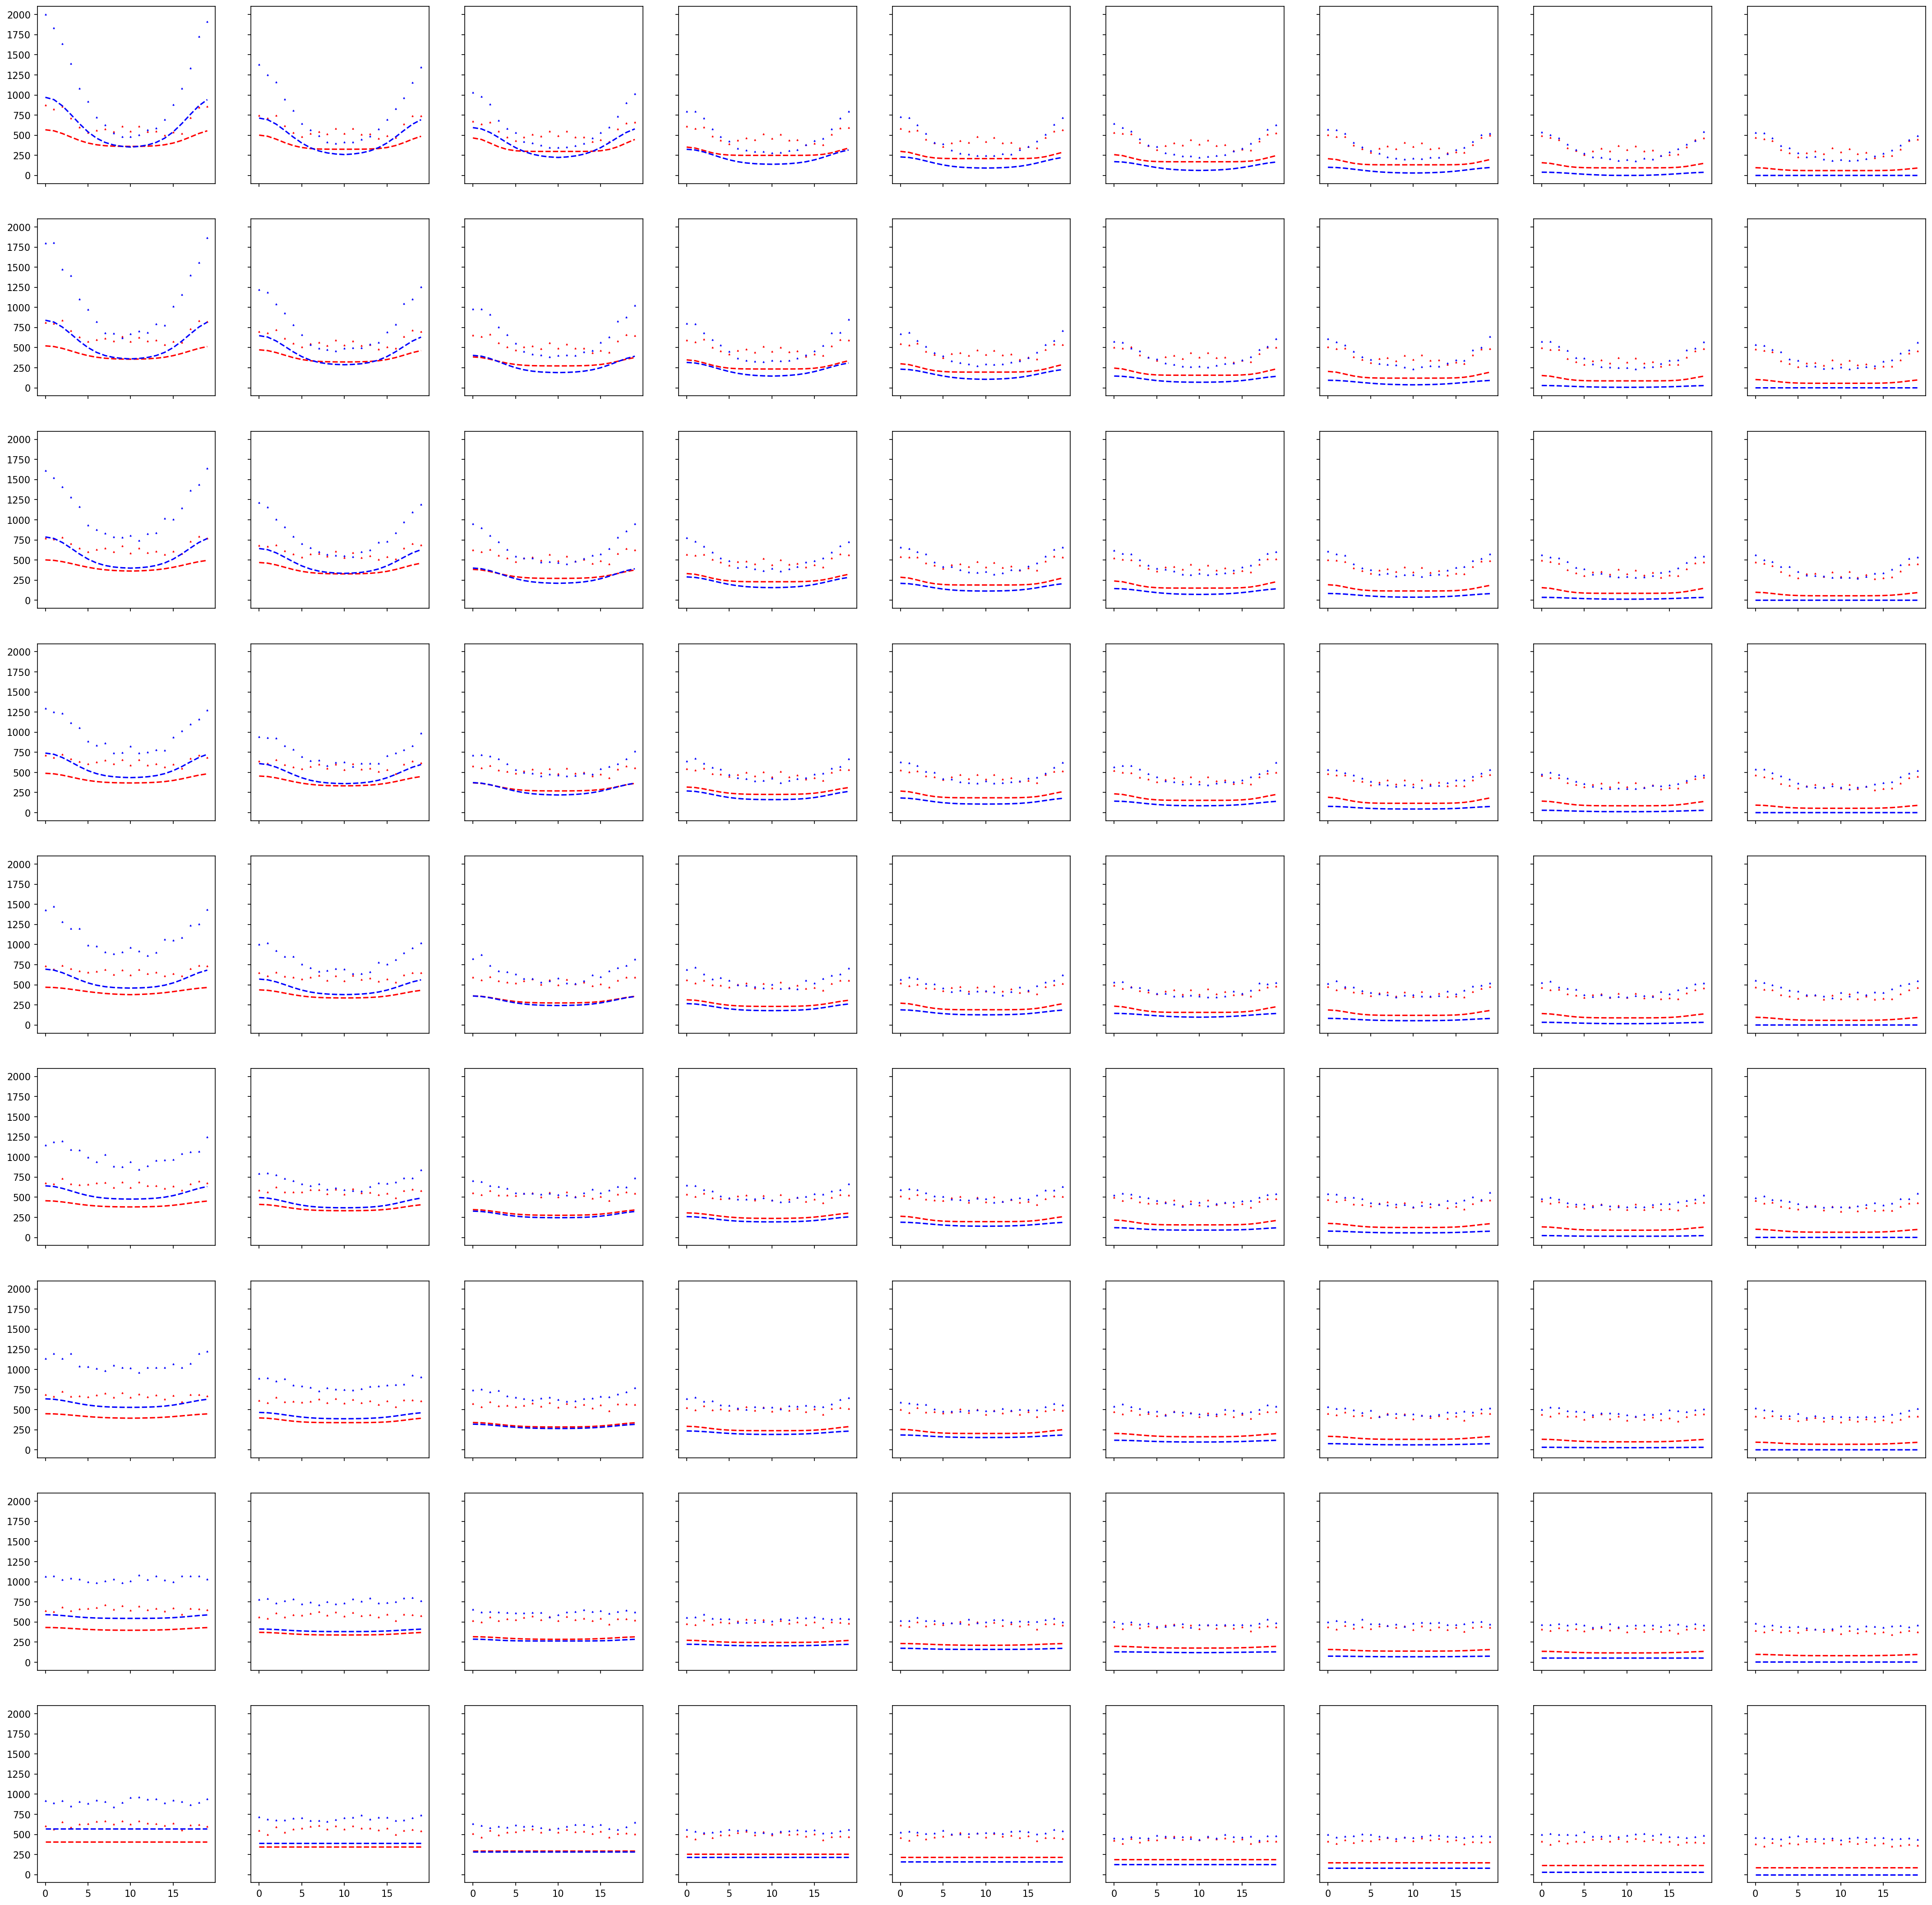

In [243]:
fig,axs = plt.subplots(9,9,figsize=(36,36),dpi=150,sharex=True,sharey=True)

for i in range(9):
    for j in range(9):
        axs[8-i,j].scatter(np.arange(20),sim_ΣrEs[2,:,i,j]+sim_μrEs[2,:,i,j]**2,s=1,c='r',marker='^')
        axs[8-i,j].scatter(np.arange(20),sim_ΣrIs[2,:,i,j]+sim_μrIs[2,:,i,j]**2,s=1,c='b',marker='^')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrEs[2,:,i,j]+dmft_μrEs[2,:,i,j]**2,'r--')
        axs[8-i,j].plot(np.arange(20),dmft_ΣrIs[2,:,i,j]+dmft_μrIs[2,:,i,j]**2,'b--')

In [272]:
sim_vsm_base_means[-1,0]

57.252996917253995

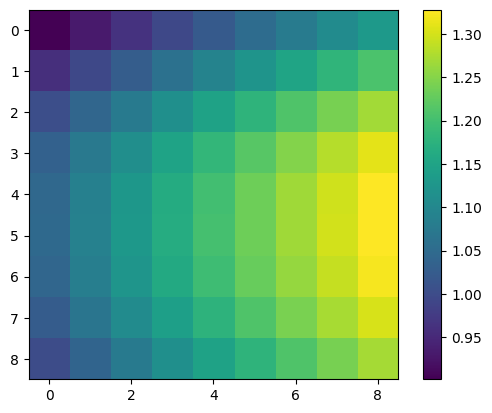

In [262]:
plt.imshow(sim_vsm_base_means/sim_vsm_base_means[-1,0])
plt.colorbar()

In [252]:
print(np.mean(sim_ΣrEs[2,:,0,0]+sim_μrEs[2,:,0,0]**2))
print(np.mean(sim_ΣrIs[2,:,0,0]+sim_μrIs[2,:,0,0]**2))

623.7681408404081
907.8279910825952


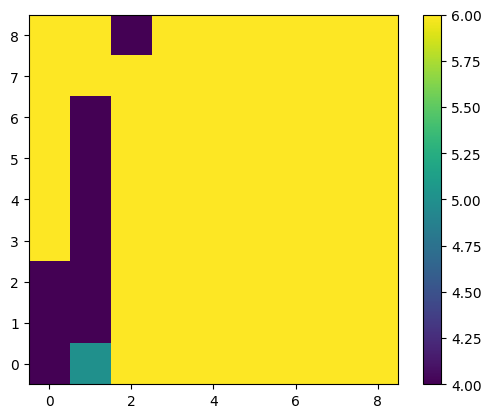

In [244]:
plt.imshow(np.count_nonzero(dmft_convs,(0,1)),origin='lower')
plt.colorbar()

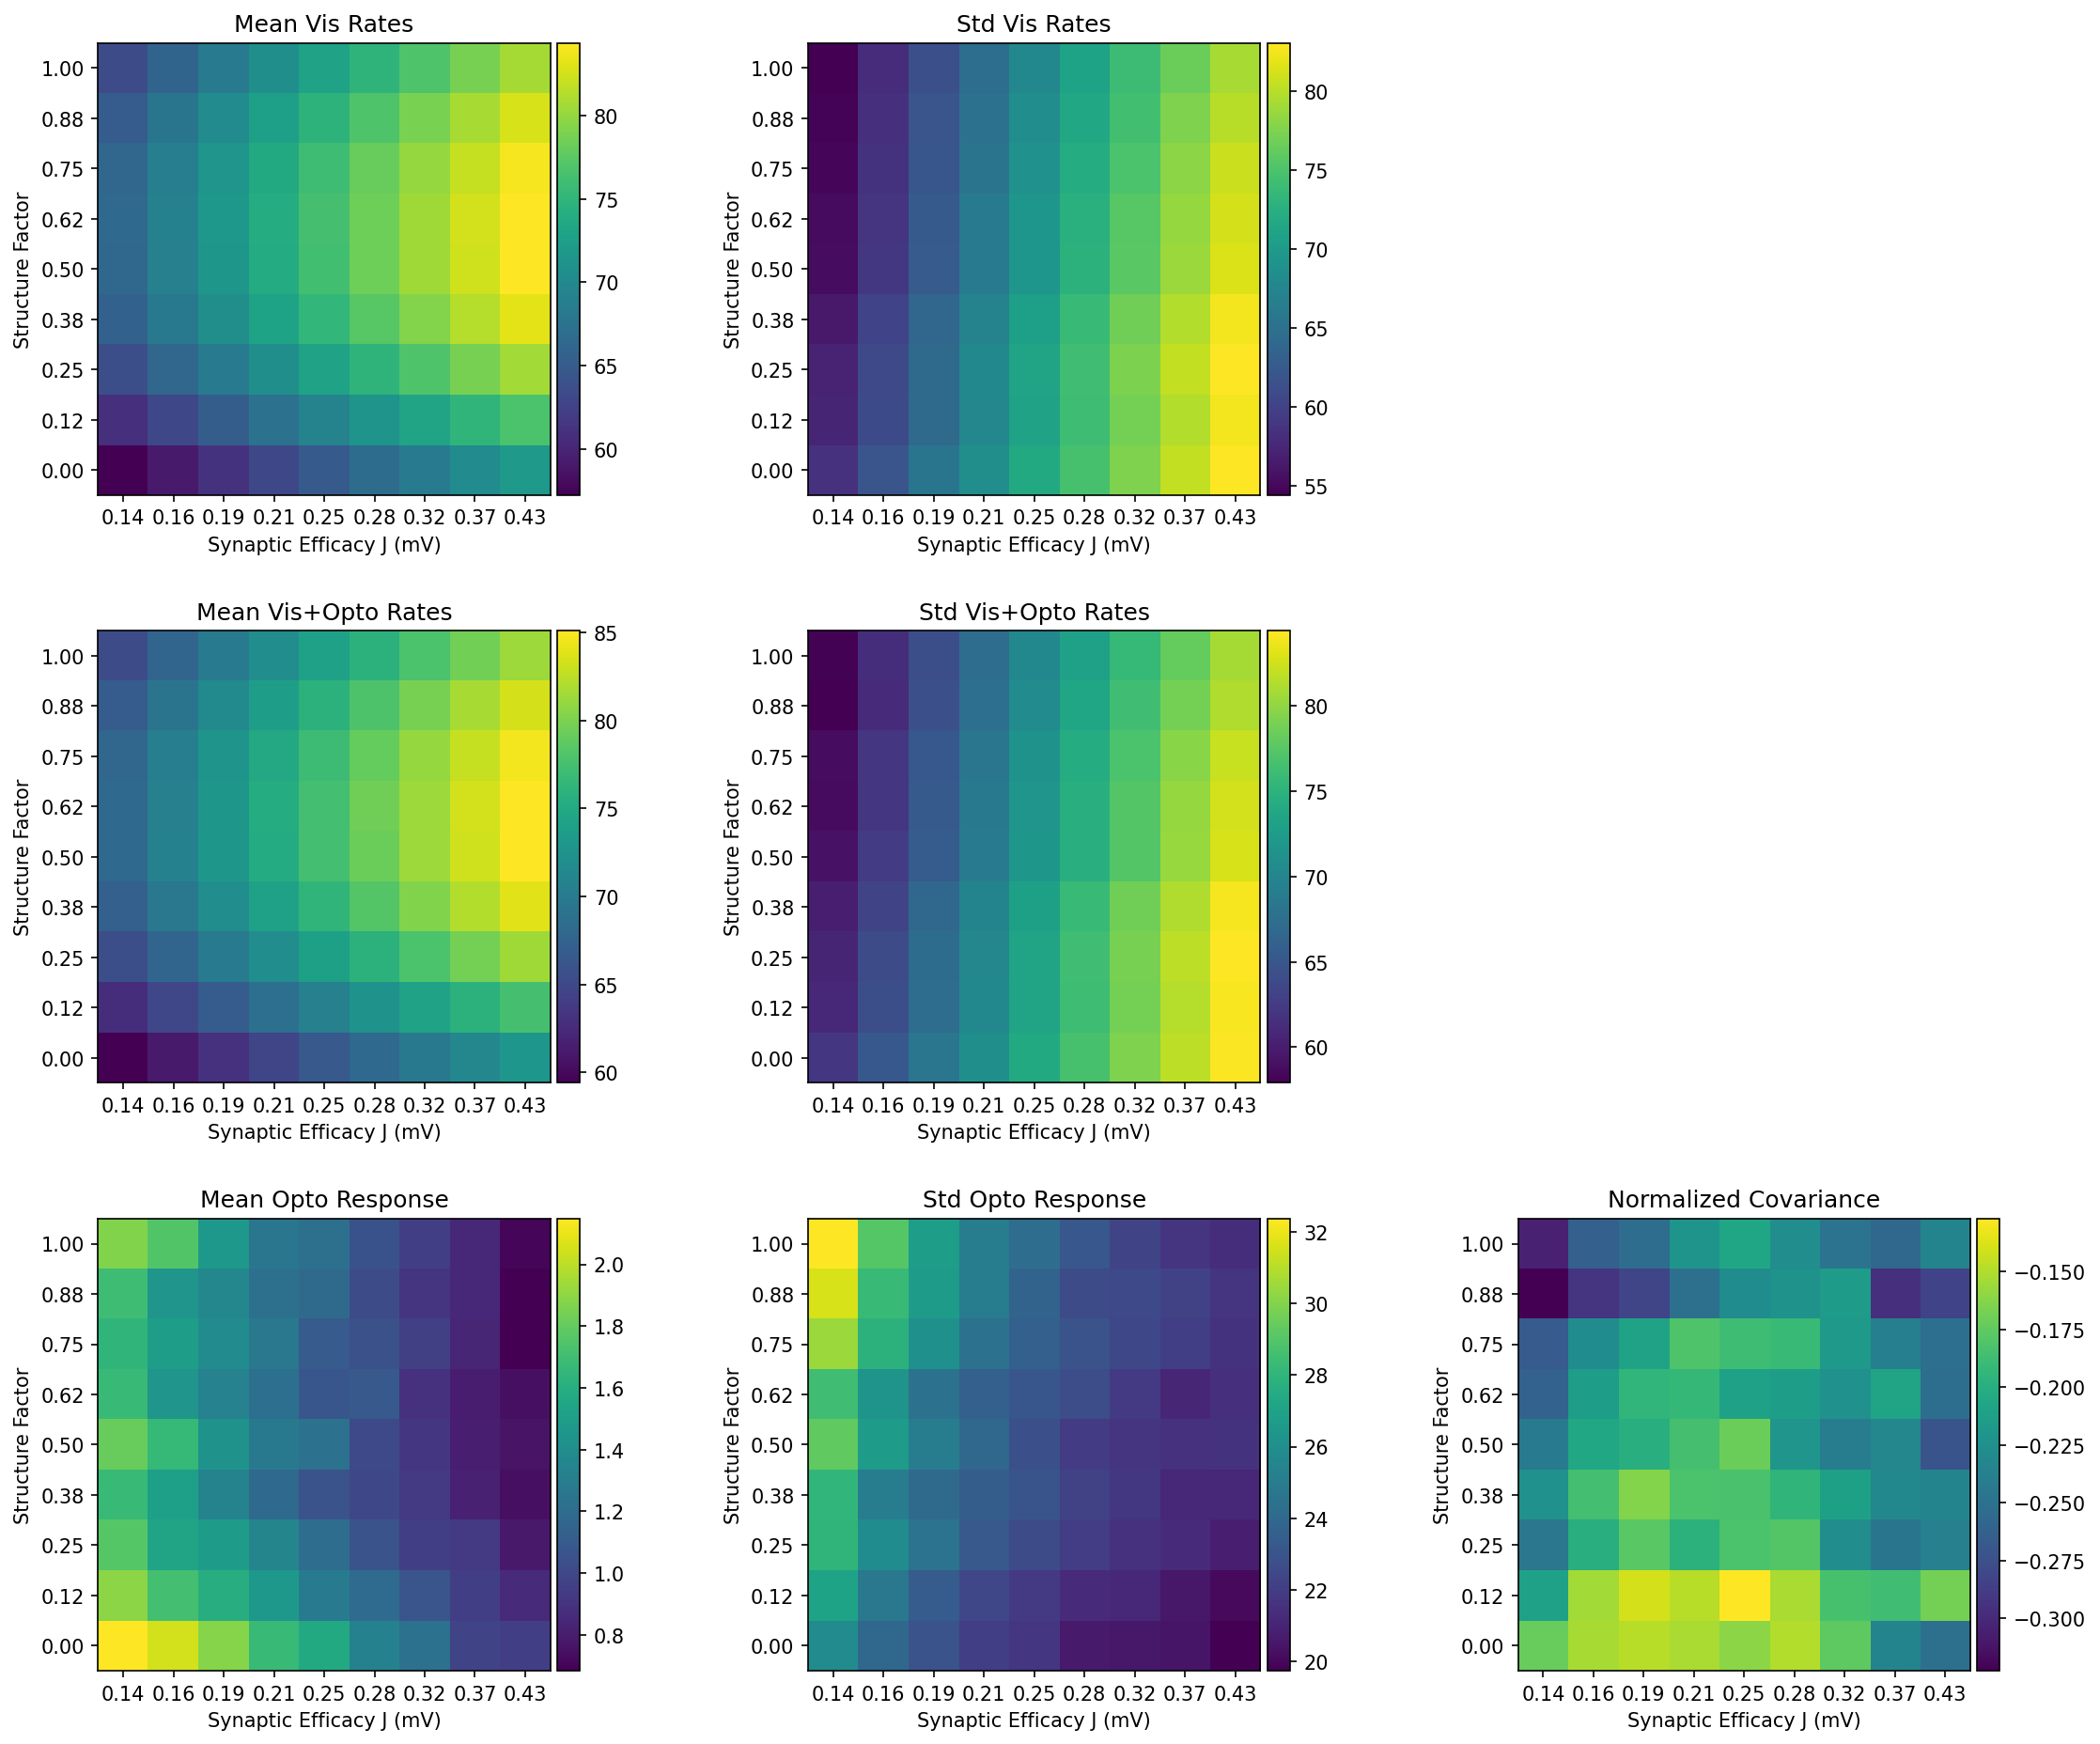

In [216]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],sim_vsm_base_means,origin='lower')
imshowbar(fig,axs[0,1],sim_vsm_base_stds,origin='lower')
imshowbar(fig,axs[1,0],sim_vsm_opto_means,origin='lower')
imshowbar(fig,axs[1,1],sim_vsm_opto_stds,origin='lower')
imshowbar(fig,axs[2,0],sim_vsm_diff_means,origin='lower')
imshowbar(fig,axs[2,1],sim_vsm_diff_stds,origin='lower')
imshowbar(fig,axs[2,2],sim_vsm_norm_covs,origin='lower')

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

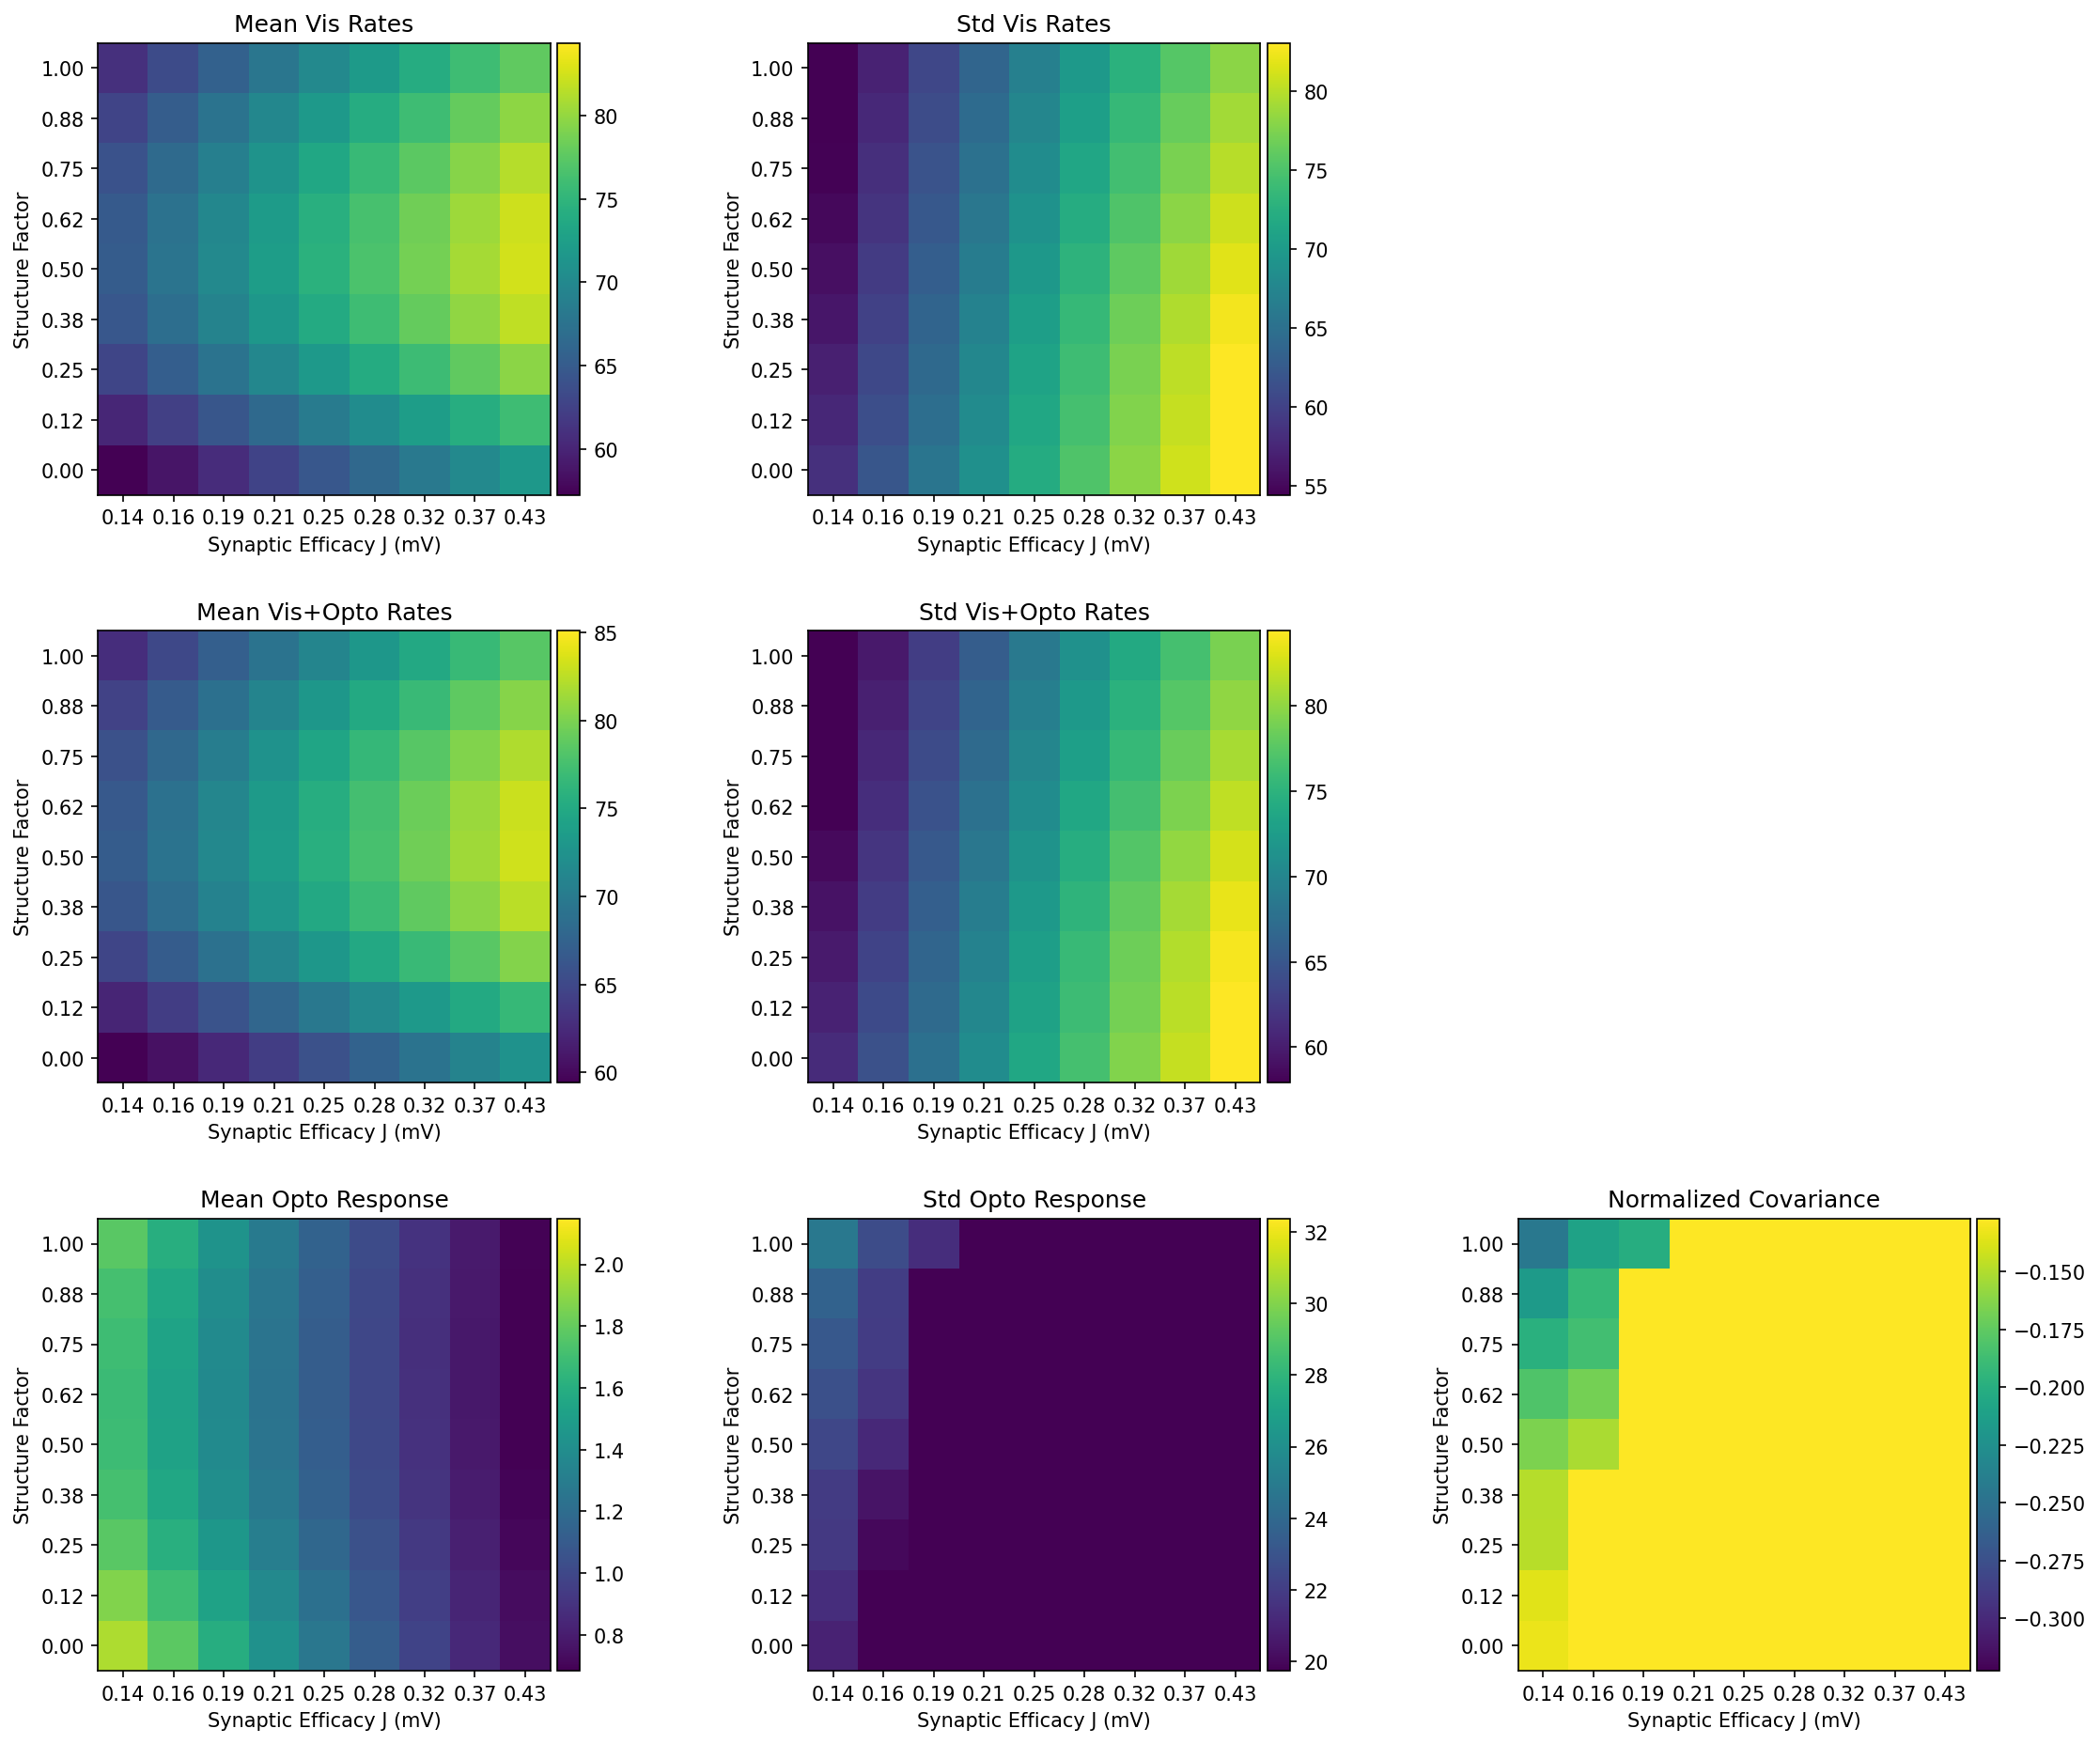

In [240]:
fig,axs = plt.subplots(3,3,figsize=(18,15),dpi=150)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

imshowbar(fig,axs[0,0],dmft_vsm_base_means,origin='lower',
          vmin=np.min(sim_vsm_base_means),vmax=np.max(sim_vsm_base_means))
imshowbar(fig,axs[0,1],dmft_vsm_base_stds,origin='lower',
          vmin=np.min(sim_vsm_base_stds),vmax=np.max(sim_vsm_base_stds))
imshowbar(fig,axs[1,0],dmft_vsm_opto_means,origin='lower',
          vmin=np.min(sim_vsm_opto_means),vmax=np.max(sim_vsm_opto_means))
imshowbar(fig,axs[1,1],dmft_vsm_opto_stds,origin='lower',
          vmin=np.min(sim_vsm_opto_stds),vmax=np.max(sim_vsm_opto_stds))
imshowbar(fig,axs[2,0],dmft_vsm_diff_means,origin='lower',
          vmin=np.min(sim_vsm_diff_means),vmax=np.max(sim_vsm_diff_means))
imshowbar(fig,axs[2,1],dmft_vsm_diff_stds,origin='lower',
          vmin=np.min(sim_vsm_diff_stds),vmax=np.max(sim_vsm_diff_stds))
imshowbar(fig,axs[2,2],dmft_vsm_norm_covs,origin='lower',
          vmin=np.min(sim_vsm_norm_covs),vmax=np.max(sim_vsm_norm_covs))

axs[0,0].set_title('Mean Vis Rates')
axs[0,1].set_title('Std Vis Rates')
axs[1,0].set_title('Mean Vis+Opto Rates')
axs[1,1].set_title('Std Vis+Opto Rates')
axs[2,0].set_title('Mean Opto Response')
axs[2,1].set_title('Std Opto Response')
axs[2,2].set_title('Normalized Covariance')

for i in range(3):
    for j in range(3):
        if i < 2 and j == 2:
            axs[i,j].axis('off')
        else:
#             axs[i,j].contour(Lexps[:,:,0],[0],colors='w',linestyles='-')
#             axs[i,j].contourf(Lexps[:,:,0],[0,1e12],colors='w',linestyles='-',alpha=0.2)
#             axs[i,j].contour(Lexps[:,:,1],[0],colors='w',linestyles='--')
#             axs[i,j].contourf(Lexps[:,:,1],[0,1e12],colors='w',linestyles='--',alpha=0.2)
            
            axs[i,j].set_xticks(np.arange(len(Js)),['{:.2f}'.format(J*1000) for J in Js],
                                fontsize=10)
            axs[i,j].set_yticks(np.arange(len(structs)),['{:.2f}'.format(struct) for struct in structs],
                                fontsize=10)

            axs[i,j].set_xlabel('Synaptic Efficacy J (mV)')
            axs[i,j].set_ylabel('Structure Factor')

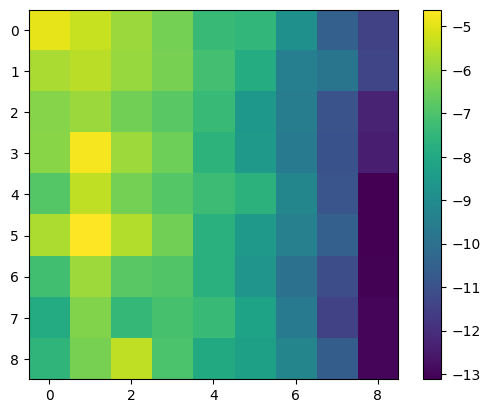

In [248]:
plt.imshow(dmft_vsm_diff_stds-sim_vsm_diff_stds)
plt.colorbar()

In [263]:
sim_vsm_base_means

array([[57.25299692, 59.23315238, 61.224277  , 63.14354008, 64.96772632,
        66.8171775 , 68.53694083, 70.34197051, 71.92273547],
       [60.88714877, 63.13315978, 65.24607373, 67.31690825, 69.34292966,
        71.25788008, 73.11620294, 74.96616031, 76.67188385],
       [63.77792842, 66.2107773 , 68.46760401, 70.69966702, 72.84671884,
        74.8959711 , 76.90005295, 78.7630963 , 80.61310019],
       [65.65389906, 68.20909266, 70.64336422, 72.95764798, 75.1497497 ,
        77.26916167, 79.28636753, 81.29224531, 83.19693938],
       [66.38522411, 69.02086134, 71.57344752, 73.96381715, 76.15480147,
        78.35471352, 80.44661118, 82.44151385, 84.3429519 ],
       [66.51548844, 69.19293006, 71.67976437, 74.06532101, 76.34471672,
        78.40147336, 80.48860876, 82.51117018, 84.34757703],
       [66.21192471, 68.86115193, 71.34140639, 73.67663202, 75.90351121,
        78.0166746 , 80.07288111, 81.98038663, 83.95236139],
       [65.15951717, 67.80863468, 70.27465978, 72.57509098, 74

In [264]:
dmft_vsm_base_means

array([[56.72855072, 58.75214996, 60.72855835, 62.66372986, 64.55891876,
        66.41472321, 68.22859192, 69.9963562 , 71.71530304],
       [60.1522163 , 62.34451959, 64.45986174, 66.50992879, 68.50185213,
        70.44065463, 72.32688503, 74.15821999, 75.93433422],
       [62.95775926, 65.32080274, 67.57991952, 69.75331811, 71.85047613,
        73.88149205, 75.84759483, 77.75050052, 79.59052536],
       [64.57551888, 67.04536505, 69.39523258, 71.64494624, 73.80928027,
        75.8973354 , 77.91291772, 79.86061635, 81.7392496 ],
       [65.15248162, 67.6693102 , 70.05874192, 72.3425034 , 74.53480512,
        76.64538772, 78.68202272, 80.64639565, 82.54098077],
       [64.92460417, 67.44455762, 69.83679994, 72.12197845, 74.31432395,
        76.42406261, 78.45932838, 80.42154098, 82.31353179],
       [64.08298464, 66.5760777 , 68.94497197, 71.20987621, 73.38373641,
        75.47716448, 77.49653663, 79.44355699, 81.32148445],
       [62.76420759, 65.20945118, 67.53906438, 69.76792222, 71

In [265]:
sim_vsm_diff_means

array([[2.14818944, 2.0498607 , 1.88072236, 1.67108086, 1.57399218,
        1.32525125, 1.23093886, 0.98160769, 0.95272845],
       [1.89183686, 1.71322057, 1.5977372 , 1.46460655, 1.2906378 ,
        1.19705239, 1.07044101, 0.95727006, 0.86094951],
       [1.76195718, 1.53865319, 1.49389108, 1.35058245, 1.20944875,
        1.06066452, 0.9564575 , 0.93020434, 0.78318282],
       [1.67028739, 1.51138047, 1.33611824, 1.18346083, 1.05866562,
        0.99989826, 0.93063582, 0.81616222, 0.74142966],
       [1.80598403, 1.66293944, 1.43243179, 1.27510283, 1.22730502,
        1.00855382, 0.91792485, 0.80724533, 0.76087099],
       [1.66895848, 1.44853993, 1.33297568, 1.22010513, 1.0767564 ,
        1.09321616, 0.89322364, 0.80294252, 0.74094738],
       [1.64115513, 1.5065927 , 1.38836881, 1.2722424 , 1.10238641,
        1.0441783 , 0.96190955, 0.83820155, 0.68889348],
       [1.69449058, 1.44444368, 1.36226911, 1.22599355, 1.18952486,
        1.01607515, 0.91078193, 0.85226073, 0.68338297],


In [266]:
dmft_vsm_diff_means

array([[1.96569443, 1.7782341 , 1.59776535, 1.4258194 , 1.26432343,
        1.11419525, 0.9765686 , 0.8519165 , 0.73987732],
       [1.86782696, 1.69435869, 1.52844904, 1.37057047, 1.22228547,
        1.08338983, 0.95457785, 0.83639669, 0.72933175],
       [1.77310972, 1.60984816, 1.45646673, 1.31149493, 1.17435717,
        1.04497488, 0.92487023, 0.81352865, 0.71187217],
       [1.71455756, 1.55533587, 1.40816222, 1.26998092, 1.13971503,
        1.0174912 , 0.90263518, 0.79576556, 0.69777995],
       [1.68643334, 1.52945113, 1.38360753, 1.24757388, 1.12038706,
        1.00112127, 0.88956393, 0.78503794, 0.68897226],
       [1.68129941, 1.52254826, 1.3768202 , 1.24047871, 1.11380552,
        0.99466949, 0.88372103, 0.77999366, 0.68498632],
       [1.69394223, 1.53213852, 1.38339961, 1.24425323, 1.11518183,
        0.99518041, 0.88325618, 0.78010324, 0.68453606],
       [1.71874587, 1.55435074, 1.39977895, 1.25726659, 1.12436192,
        1.0013372 , 0.88729571, 0.78275723, 0.68628745],


In [267]:
sim_vsm_diff_stds

array([[25.85204109, 24.02594281, 22.95591743, 22.0693634 , 21.71411558,
        20.66700351, 20.5372647 , 20.46971481, 19.7410042 ],
       [27.05350069, 24.82064496, 23.41715047, 22.41185355, 21.89238503,
        21.31813437, 21.20139722, 20.55738625, 20.08327882],
       [28.0059838 , 25.89451721, 24.53482844, 23.2818816 , 22.60529926,
        22.04587057, 21.56434171, 21.28472041, 20.79854381],
       [28.04920415, 25.11466359, 24.08499135, 23.44919819, 23.02203092,
        22.18263001, 21.7739111 , 21.16895767, 21.15793803],
       [29.27960831, 26.65069516, 25.11271674, 23.97383424, 22.82763768,
        21.95629865, 21.69131112, 21.5165338 , 21.60689907],
       [28.49288851, 26.2936949 , 24.48000506, 23.60737912, 23.1111041 ,
        22.74319768, 21.86479236, 21.08849884, 21.44585756],
       [30.44490725, 27.86001053, 26.07085154, 24.44247113, 23.62760846,
        22.97799048, 22.50218903, 22.08373653, 21.58480044],
       [31.5935004 , 28.23994672, 26.71261674, 25.04414487, 23

In [268]:
dmft_vsm_diff_stds

array([[20.93565524, 18.70943172, 17.06081256, 15.67351452, 14.3196499 ,
        13.17975298, 11.68863039,  9.94742514,  8.29466572],
       [21.37159572, 19.31942702, 17.47655215, 16.04076195, 14.73990102,
        13.44929381, 11.7654242 , 10.75768308,  8.7253355 ],
       [21.84751047, 20.0001838 , 18.0986614 , 16.49001453, 15.23624051,
        13.46287682, 12.00481554, 10.35133587,  8.51792956],
       [21.93314417, 20.39483024, 18.21911722, 16.95443169, 15.41206525,
        13.66917858, 12.16710586, 10.18061665,  8.74539226],
       [22.41904411, 21.21136593, 18.70451965, 17.11037012, 15.55286739,
        14.28636061, 12.47853664, 10.64583569,  8.48649175],
       [22.83555798, 21.67804158, 18.89180971, 17.19175356, 15.37574039,
        14.22346504, 12.46491104, 10.58534975,  8.3330449 ],
       [23.23892599, 22.00062105, 19.26686699, 17.50881462, 15.92060958,
        14.30408264, 12.57514247, 10.96355906,  8.52716284],
       [23.6958832 , 22.02430363, 19.26871427, 17.95348454, 16

In [117]:
oris = np.arange(Nori)*180/Nori
oris[oris > 90] = 180 - oris[oris > 90]
print(oris)
del oris

[ 0.  9. 18. 27. 36. 45. 54. 63. 72. 81. 90. 81. 72. 63. 54. 45. 36. 27.
 18.  9.]


In [271]:
sim_vsm_norm_covs

array([[-0.17287767, -0.15253579, -0.1480358 , -0.15150215, -0.16123024,
        -0.14992138, -0.17556401, -0.23465793, -0.2507885 ],
       [-0.21088725, -0.15377498, -0.13981322, -0.14796951, -0.12702136,
        -0.15222334, -0.18370808, -0.18677282, -0.16753547],
       [-0.24479645, -0.2002234 , -0.17724622, -0.19732628, -0.18241618,
        -0.17935908, -0.22649442, -0.24684963, -0.23762211],
       [-0.22399102, -0.18542038, -0.16299481, -0.18217792, -0.18355214,
        -0.19434326, -0.21150998, -0.23150547, -0.23411741],
       [-0.24186071, -0.2064384 , -0.20013295, -0.18478529, -0.17082399,
        -0.22066182, -0.24014284, -0.23178511, -0.27187705],
       [-0.26100845, -0.21347962, -0.19423028, -0.19232356, -0.21062056,
        -0.21277154, -0.2240685 , -0.20878382, -0.25218298],
       [-0.26650493, -0.22741633, -0.21007031, -0.1812844 , -0.18805685,
        -0.19099707, -0.21721393, -0.23823138, -0.25120082],
       [-0.32269616, -0.29301628, -0.28179619, -0.25071873, -0

In [269]:
dmft_vsm_norm_covs

array([[-0.13240534, -0.06495316, -0.00673208,  0.04342113,  0.08342529,
         0.13021044,  0.22220341,  0.39080247,  0.63456731],
       [-0.13613341, -0.07858363, -0.02428494,  0.01940266,  0.06800799,
         0.11380548,  0.21608235,  0.27164911,  0.55563794],
       [-0.14798427, -0.10175779, -0.04681665, -0.00392731,  0.03521615,
         0.11972765,  0.19863408,  0.34100051,  0.61805232],
       [-0.14890747, -0.11642579, -0.05229374, -0.01988146,  0.02645125,
         0.10523999,  0.17786441,  0.37258482,  0.55816991],
       [-0.16588075, -0.15214711, -0.07641477, -0.03740932,  0.01091938,
         0.05047151,  0.1484484 ,  0.29378657,  0.61599321],
       [-0.18072457, -0.16795076, -0.09449001, -0.04583249,  0.01200765,
         0.0486134 ,  0.13592897,  0.2832961 ,  0.64488896],
       [-0.19879935, -0.1862907 , -0.11851493, -0.06995467, -0.02478078,
         0.02589887,  0.11022434,  0.21861878,  0.549844  ],
       [-0.21574669, -0.19191886, -0.12405322, -0.0991343 , -0

In [270]:
0.5*(dmft_vsm_opto_stds**2 - dmft_vsm_base_stds**2 - dmft_vsm_diff_stds**2)

array([[ -58.03348146,  -22.73638932,   -1.95951403,   10.66679421,
          17.10655351,   22.61831955,   30.35833588,   38.67039974,
          43.65916951],
       [ -62.1782699 ,  -29.3305746 ,   -7.41734534,    4.99242076,
          14.77573479,   20.58553331,   29.91124327,   31.43733898,
          42.30153872],
       [ -70.63492265,  -40.70386409,  -15.33533393,   -1.06791676,
           8.17518267,   21.7005231 ,   28.62626833,   36.53825722,
          44.84286278],
       [ -71.63384824,  -48.42720439,  -17.35818862,   -5.71498094,
           6.28301216,   19.66371689,   26.33077388,   38.61653676,
          42.68988759],
       [ -83.3739124 ,  -68.45433856,  -26.73439854,  -10.95213068,
           2.64130678,   10.3012401 ,   23.11547663,   33.29595327,
          44.36416508],
       [ -94.24112558,  -78.92636014,  -33.72352871,  -13.54608511,
           2.83876813,    9.83482958,   21.11982821,   31.74322255,
          44.78085542],
       [-107.36112963,  -90.16979148,  -